<a href="https://colab.research.google.com/github/resfy/Final_Project/blob/main/EEG%20Signal%20Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#revision history

1. use good SNR data

Bug :

1. PCA --> kalau jumlah kemunculan kanalnya sama, jadi bias karena yang diurutan pertama pasti dari kelas thumb --> mungkin bisa diatasi dengan melihat variansi yang dibawa oleh kanal

# ENVIRONTMENT PREPARATION

In [ ]:
!pip install mne

     |████████████████████████████████| 6.9 MB 8.0 MB/s 


In [ ]:
import scipy.io as sio
import scipy
import math
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pydrive.files import GoogleDriveFile
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# IMPORT DATASET FROM GDRIVE

dataset: 0-40 Hz 
frequency of interest : 
- 0-5Hz --> MRCP
- 8-12 --> alpha rythm
- 13-30 --> beta rythm

number of channel = 21
sampling frequency = 200 


In [ ]:
# 2. Get .mat File
#folder 0_f
listed = drive.ListFile({'q': "title contains '.fif' and '1Hnk0B0_vtOWMsMpnpP-HUU52H3nLbmf9' in parents"}).GetList()
list_id = []
list_title = []
#get file id and title
for file in listed:
    list_id.append(file['id'])
    list_title.append(file['title'])

In [ ]:
list_title

['SubjectB-151110-epo.fif',
 'SubjectB-160316-epo.fif',
 'SubjectC-151204-epo.fif',
 'SubjectA-160405-epo.fif',
 'SubjectF-151027-epo.fif',
 'SubjectF-160209-epo.fif',
 'SubjectA-160408-epo.fif',
 'SubjectI-160719-epo.fif',
 'SubjectH-160804-epo.fif',
 'SubjectF-160210-epo.fif',
 'SubjectG-160413-epo.fif',
 'SubjectB-160311-epo.fif',
 'SubjectB-160309-epo.fif',
 'SubjectC-160429-epo.fif',
 'SubjectE-160321-epo.fif',
 'SubjectE-160429-epo.fif',
 'SubjectE-160415-epo.fif',
 'SubjectI-160723-epo.fif',
 'SubjectG-160428-epo.fif']

In [ ]:
dataset_list = []
#load each epoch file
for id, title in zip(list_id, list_title):
    each_file = drive.CreateFile({'id': id})
    each_file.GetContentFile(title)
    dataset = mne.read_epochs(title)
    dataset_list.append(dataset)

#file .fif read as list

Reading SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Reading SubjectB-160316-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading SubjectC-151204-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Reading SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices availa

In [ ]:
#number of dataset
len(dataset_list)

19

In [ ]:
def cropEEG(epochs, tmin=0, tmax=0.845):
  """crop epochs length 
    
    Parameters
    ----------
    epochs : MNE epochs object

    Returns
    ------
    copy : cropped epochs
    """
  copy = epochs.copy().crop(tmin=0, tmax=0.845, include_tmax=True)
  return copy

In [ ]:
'''for subject in dataset_list:
   subject.drop_channels('A1')
   subject.drop_channels('A2')'''

"for subject in dataset_list:\n   subject.drop_channels('A1')\n   subject.drop_channels('A2')"

In [ ]:
a = dataset_list[0].ch_names
print(a)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'STI']


In [ ]:
for data,title in zip(dataset_list, list_title):
  print(title)
  print(data,'\n')

SubjectB-151110-epo.fif
<EpochsFIF |  958 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
 'index': 192
 'middle': 186
 'pinky': 181
 'ring': 177
 'thumb': 222> 

SubjectB-160316-epo.fif
<EpochsFIF |  959 events (all good), 0 - 0.85 sec, baseline off, ~25.1 MB, data loaded,
 'index': 173
 'middle': 197
 'pinky': 189
 'ring': 191
 'thumb': 209> 

SubjectC-151204-epo.fif
<EpochsFIF |  958 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
 'index': 202
 'middle': 196
 'pinky': 203
 'ring': 190
 'thumb': 167> 

SubjectA-160405-epo.fif
<EpochsFIF |  959 events (all good), 0 - 0.85 sec, baseline off, ~25.1 MB, data loaded,
 'index': 172
 'middle': 198
 'pinky': 189
 'ring': 191
 'thumb': 209> 

SubjectF-151027-epo.fif
<EpochsFIF |  957 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
 'index': 173
 'middle': 198
 'pinky': 189
 'ring': 191
 'thumb': 206> 

SubjectF-160209-epo.fif
<EpochsFIF |  956 events (all good), 0 - 0.85 sec, 

#CHANNEL SELECTION

##Multiclass CSP
sumber  = Wang, Yijun dkk

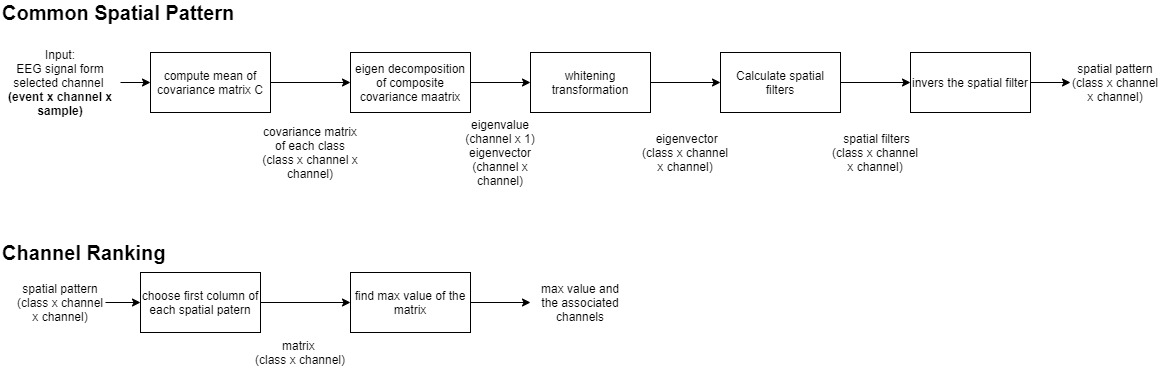


In [ ]:
def ave_cov_matrix (each_class):

  """Calculate average covariance matrix of each EEG class. 
    
    Parameters
    ----------
    each_class : EEG signal from one class

    Returns
    ------
    average = average covariance matrix
    """

  sum = np.zeros((19,19))    #((21,21))
  for each_trial in each_class:
    each_trial = each_trial - np.mean(each_trial)
    #covariance equation = (X * X.T)/trace(X * X.T)
    var =  np.dot(each_trial,np.transpose(each_trial))
    covariance = var/np.trace(var)
    sum += covariance
  average = sum/len(each_class)
  return average

In [ ]:
def CSP (dataset):

  """calculate EEG spatial pattern using multiclass CSP. 
    
    Parameters
    ----------
    dataset : MNE epochs
      EEG epochs

    Returns
    ------
    spatial pattern
    invers of spatial pattern
    """

  #assign each EEG class matrix to dictionary
  EEG_class ={}
  EEG_class["thumb"] = dataset['thumb'].get_data(picks='eeg')
  EEG_class["index"] = dataset['index'].get_data(picks='eeg')
  EEG_class["middle"] = dataset['middle'].get_data(picks='eeg')
  EEG_class["ring"] = dataset['ring'].get_data(picks='eeg')
  EEG_class["pinky"] = dataset['pinky'].get_data(picks='eeg')

  ave_covariance = {}
  composite = np.zeros((19,19))    #((21,21))
  for key,value in EEG_class.items():
    #compute covariance matrix average of each class
    ave_covariance[key] = ave_cov_matrix(value)
    #compute composite of all covariace matrix
    composite += ave_covariance[key]

  #do eigen decomposition
  Evalue,Evector = scipy.linalg.eig(composite)

  #print("Eigenval shape: ", Evalue.shape)
  #print("Eigenvec shape: ", Evector.shape)

  #do whitening transformation
  #whitened = np.dot(np.sqrt(scipy.linalg.inv(np.diag(Evalue))),np.transpose(Evector))
  whitened = np.dot(scipy.linalg.inv(np.sqrt(np.diag(Evalue))),np.transpose(Evector))
  #whitened = np.dot(np.diag(1./np.sqrt(Evalue)),np.transpose(Evector))
  #PASTIKAN KODE DIBAWAH INI BENAR --> COCOKKAN DENGAN PAPER
  Eval_dict = {}
  Evec_dict = {}
  SF_dict = {}
  CSP_dict = {}

  for key,value in ave_covariance.items():
    #transformed each covariance matrix
    S_cov = np.dot(whitened,np.dot(value,np.transpose(whitened)))
    not_s_cov = np.dot(whitened,np.dot((composite-value),np.transpose(whitened)))
    
    #eigen decomposition using OVR term
    Eval_dict[key], Evec_dict[key] = scipy.linalg.eig(S_cov,not_s_cov)#,not_s_cov

    '''ord1 = np.argsort(Eval_dict[key])
    ord1 = ord1[::-1]
    Eval_dict[key] = Eval_dict[key][ord1]
    Evec_dict[key] = Evec_dict[key][:,ord1]'''

    #spatial filter
    SF_dict[key] = np.dot(np.transpose(Evec_dict[key]),whitened) 

    #CSP = iverse of spatial filter
    CSP_dict[key] = scipy.linalg.inv(SF_dict[key])
    #print(CSP_dict[key])
  
  return (SF_dict,CSP_dict)  

In [ ]:
def channelRank (spatialpattern,dataset,n_chan): #

  """rank channels contribution score
    
  Parameters
  ----------
  dataset : MNE epochs
  spatialpattern : spatial patten EEG
  nchan : number of selected channel for each class

  Returns
  ------
  rank_per_class : (spatial_score,ch_names)
  rank_all : (ch_names, number of channel usage)
  """

  col = 0 #n-first column are choosed
  row = 19 #21
  ch_names = dataset.ch_names
  contrib_score = {}
  rank_per_class = {}

  #sort EEG contribution score based on spatial pattern
  for key,value in spatialpattern.items():
    #contrib_score[key] = np.zeros((row))
    #first column of spatial pattern --> show channel contribution pattern
    spatialcol = value[:,col] 

    '''PCrank = []
    for row in spatialcol.T:
      PCrank.append(max(np.abs(row)))'''

    #pick absolute value of spatial pattern
    PCrank = np.absolute(spatialcol)

    #for i in range(len(spatialcol_real)):
     # contrib_score[key][i] = Normalizer(spatialcol_real[i], norm='l1')/Normalizer(spatialcol_real, norm='l1')
    #print(contrib_score)

    #find max value of contrib score and return it position (column) --> indicate most relevan channels
    rank_per_class[key] = sorted(zip(PCrank, ch_names), key=lambda item: item[0], reverse=True)[:n_chan] 
    
  #list relevan channel per class into a list and count its usage number
  #tidak ada pembobotan jadi ranking 1 di suatu kelas sama dengan ranking ke n,
  #yang penting adalah jumlah kemunculan kanal tersebut disetiap kelas
  subset_dict={}
  for value in rank_per_class.values():
    #get chnames from rank_per_class dict values
    buffer = list(map(itemgetter(1),value))
    #add relevan channel to subset dict and count its usage number
    for item in buffer:
      if item in subset_dict:
        subset_dict[item] += 1
      else:
        subset_dict[item] = 1
  
  #rank channel usage from all class
  rank_all = sorted(subset_dict.items(), key=lambda item: item[1], reverse=True)

  return rank_per_class, rank_all

##PCA (Ong dkk)
whitening transformation in CSP is equivalent to PCA (wang, yunhua dkk)

rules to choose most relevan channel in PCA channel selection:
- associate one channel with each of the first m PCs with the highest coefficient, in absolute value, in successive PC. These m channels are deleted (Jolliffe IT)

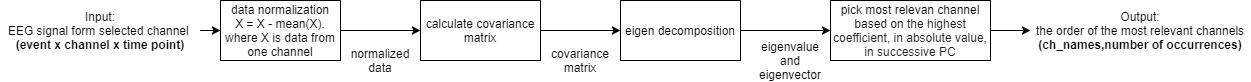

In [ ]:
def pca_eeg(dataset,n_chan,n_chan_perclass):

  """rank channels the appearance of the channel as the most relevant channel in each event using PCA
    
  Parameters
  ----------
  dataset : MNE epochs
  nchan : number of selected channel for each class

  Returns
  ------
  rank : (ch_names, number of channel usage)
  """
  
  ch_names = dataset.ch_names

  #assign each EEG class matrix to dictionary
  EEG_class ={}
  EEG_class["thumb"] = dataset['thumb'].get_data(picks='eeg')
  EEG_class["index"] = dataset['index'].get_data(picks='eeg')
  EEG_class["middle"] = dataset['middle'].get_data(picks='eeg')
  EEG_class["ring"] = dataset['ring'].get_data(picks='eeg')
  EEG_class["pinky"] = dataset['pinky'].get_data(picks='eeg')

  perclass = {}
  rank_all = {}

  for key,data in EEG_class.items():
    subset_dict = {}
    #print(rank_all)
    for trial in data:
      #normalized the data
      X = trial - np.mean(trial)

      #compute covariance matrix --> X dimension is channel x time point
      #channel(row) as variable and time point(column) as observation
      A = np.cov(X)
      #print('len A: ', len(A))

      eigenval,eigenvec = scipy.linalg.eig(A)
      #print('len eigenvec: ', len(eigenvec))

      '''#calculate PC variation
      E = eigenvec.T
      D = np.dot(np.dot(np.linalg.inv(E),A),E)
      #D = np.dot(np.linalg.inv(E),np.dot(A,E))
      variation = np.abs(np.diagonal(D))
      #print(variation)'''

      m_first_row = eigenvec#[n_chan,:]# first m PC

      PCrank = []
      for row in m_first_row:
        PCrank.append(max(np.abs(row)))

      #eigenvec is principal component, eigenval is principal component variation
      # Make a list of eigenvector, chnames) tuples 
      channel_var = [(PCrank[i], ch_names[i]) for i in range(len(PCrank))]

      # Sort the (eigenvector koefisien, chnames) tuples from high to low
      channel_var.sort(key=lambda k: k[0], reverse=True)

      #pick channel wich have biggest eigenvec coeficient
      relevan_chan = channel_var[:n_chan] 
     
      
      buffer = list(map(itemgetter(1),relevan_chan))
      #add relevan channel to subset dict and count its usage number
      for item in buffer:
        #hitung kemunculan kanal sebagai kanal relevan dalam semua trial dalam 1 kelas
        if (item in subset_dict) :
          subset_dict[item] += 1
        else:
          subset_dict[item] = 1
        #hitung kemunculan kanal sebagai kanal relevan dalam semua trial secara keseluruhan
        if (item in rank_all):
          rank_all[item] += 1
        else:
          rank_all[item] = 1
      rank = sorted(subset_dict.items(), key=lambda item: item[1], reverse=True)
      
    perclass[key] = rank[:n_chan_perclass]

  #gabungkan kanal2 paling relevan dari setiap kelas
  rank_all_list = sorted(rank_all.items(), key=lambda item: item[1], reverse=True)

  '''print(channel_var)
  print(variation)'''
 
  return rank_all_list, perclass

In [ ]:
#pca_eeg(dataset_list[0],1,2)

In [ ]:
#dataset_list[0].ch_names

In [ ]:
def getVariation(variation,chan_index):
  chan_var = 0
  sum = np.sum(variation)
  for i in chan_index:
    chan_var +=variation[i]
  persen = (chan_var/sum)*100
  return persen

#SEARCHING ALGORITHM

##Sequential Searching for best channel subset
Plot accuracy lost after delete irrelavant channel incrementally

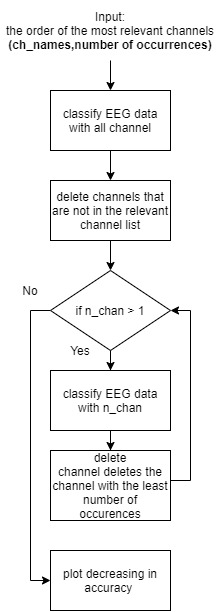

In [ ]:
def sequentialSearching(subject, channelScore,SVMkernel,features_extraction,
                       FTA_lfreq, FTA_hfreq,FTA_lfreq2, FTA_hfreq2, FTAmethod,split, nfold):
  

  all_channels = subject.ch_names
  accuracyLost = []
  channels = list(map(itemgetter(0),channelScore))
  modus= list(map(itemgetter(1),channelScore))
  
  channels.reverse()
  modus.reverse()
#  print('modus ',modus)
#  print(channels)
  copy = subject.copy()
  

  #add classification using all channel if selected channel < 19 --> all channel-1 (exclude STI channel)
  if len(channels) != (len(all_channels)-1):
    #Choose features extraction method
#    print('jumlah kanal yang dipakai klasifikasi (awal): ', len(subject.ch_names)-1)
    if features_extraction == 'FTA':
      features =FTAfeatures(subject,None,FTA_lfreq,FTA_hfreq,method=FTAmethod,lfreq2=FTA_lfreq2,hfreq2=FTA_hfreq2)
    elif features_extraction == 'STFT':
      features =STFTfeatures(subject,None,FTA_lfreq,FTA_hfreq,FTA_lfreq2,FTA_hfreq2)
    elif features_extraction == 'BandPower':
      features = bandpower_extract(subject,band, window_sec, relative)

    #Classification
    acc, mean_acc =  SVMclassifier(features, SVMkernel, split, nfold)
    accuracyLost.append(mean_acc)

    #print(all_channels)
    for ch in all_channels:
      #print('ch',ch)
      if ch not in channels:
        copy.drop_channels(ch)
  
  duplicated_modus, repeated = checkDuplicate(modus)
  used= []
#  print('duplicated_modus ', duplicated_modus)
  for i in range(len(channels)):
    chan= channels[i]
#    print(i)

    if modus[i] in duplicated_modus.keys() and modus[i] not in used:

      awal = len(duplicated_modus[modus[i]])

      if len(duplicated_modus[modus[i]]) == awal:
        #'''tambahin klasifikasi semua kanal dengan modus itu dulu'''
#        print('jumlah kanal yang dipakai klasifikasi (copy): ', len(copy.ch_names))
        if features_extraction == 'FTA':
          features =FTAfeatures(copy,None,FTA_lfreq,FTA_hfreq,method=FTAmethod,lfreq2=FTA_lfreq2,hfreq2=FTA_hfreq2)
        elif features_extraction == 'STFT':
          features =STFTfeatures(copy,None,FTA_lfreq,FTA_hfreq,FTA_lfreq2,FTA_hfreq2)
        elif features_extraction == 'BandPower':
          features = bandpower_extract(copy,band, window_sec, relative)

        #Classification 
        acc, mean_acc =  SVMclassifier(features, SVMkernel, split, nfold)
        #print('exclude channel: {} and the acc is {}'.format(exclude,mean_acc))
        accuracyLost.append(mean_acc)
	
      #ITERASI UNTUK MENGURANGI KANAL YANG MODUS NYA SAMA
      while len(duplicated_modus[modus[i]]) >= 1:
#        print('masuk while')
        maxacc=0
        drop_channel =''

#        print('used ', used)
        used.append(modus[i])
#        print('duplicated_modus[modus[i]] ',duplicated_modus[modus[i]])
        dummies = [channels[j] for j in duplicated_modus[modus[i]]]
#        print('dummies ', dummies)

        k=0 

        if len(duplicated_modus[modus[i]])==1 :
          del duplicated_modus[modus[i]][0]
          #copy2.drop_channels(dummies[0])
          if len(copy.ch_names)>1:
              copy.drop_channels(dummies[0])
              print('dropped channel ', dummies[0])

        else:

          #ITERASI MENCARI KOMBINASI KANAL TERBAIK
          for dummy in dummies:
            copy2=copy.copy()
            #print('{}, {} dtype {}'.format([dummy],dummy,type(dummy)))
            exclude =[dummy]
            '''tujuan drop untuk mencari kombinasi n_modus-1 kanal yang menghasilkan akurasi paling tinggi'''
            subset = copy2.drop_channels(exclude)
            #Choose features extraction method
            if features_extraction == 'FTA':
              features =FTAfeatures(subset,None,FTA_lfreq,FTA_hfreq,method=FTAmethod,lfreq2=FTA_lfreq2,hfreq2=FTA_hfreq2)
            elif features_extraction == 'STFT':
              features =STFTfeatures(subset,None,FTA_lfreq,FTA_hfreq,FTA_lfreq2,FTA_hfreq2)
            elif features_extraction == 'BandPower':
              features = bandpower_extract(subset,band, window_sec, relative)

            #Classification 
            acc, mean_acc =  SVMclassifier(features, SVMkernel, split, nfold)
#              print('exclude channel: {} and the acc is {}'.format(exclude,mean_acc))
            
            if mean_acc>maxacc:
              maxacc=mean_acc
              maxindex = k
              drop_channel =dummy #channels[maxindex]   
            k +=1
#              print('exclude channel: {} and the maxacc is {}'.format(drop_channel,maxacc))
#            print('jumlah kanal terpilih: ', len(copy2.ch_names))
          accuracyLost.append(maxacc)
          # '''tujuan drop untuk tidak mengikut sertakan kanal pada loop selanjutnya, kalo tingga satu
          #berarti gabakal lanjut ke loop selanjutnya'''
          if len(copy.ch_names)>1:
              copy.drop_channels(drop_channel)
              print('dropped channel ', drop_channel)
#                print('kanal tersisa ',copy.ch_names)
#            print('maxindex: ',maxindex)
          del duplicated_modus[modus[i]][maxindex]


    elif modus[i] not in duplicated_modus.keys():
      if len(copy.ch_names)>=1:
        #Choose features extraction method
#        print('jumlah kanal yang dipakai klasifikasi (copy): ', len(copy.ch_names))
        if features_extraction == 'FTA':
          features =FTAfeatures(copy,None,FTA_lfreq,FTA_hfreq,method=FTAmethod,lfreq2=FTA_lfreq2,hfreq2=FTA_hfreq2)
        elif features_extraction == 'STFT':
          features =STFTfeatures(copy,None,FTA_lfreq,FTA_hfreq,FTA_lfreq2,FTA_hfreq2)
        elif features_extraction == 'BandPower':
          features = bandpower_extract(copy,band, window_sec, relative)

        #Classification
        acc, mean_acc =  SVMclassifier(features, SVMkernel, split, nfold)
        accuracyLost.append(mean_acc)
        
        #drop irrelevan channel incrementally, after classify
        #'''tujuan drop untuk tidak mengikut sertakan kanal pada loop selanjutnya, kalo tingga satu
        #berarti gabakal lanjut ke loop selanjutnya'''
        if len(copy.ch_names)>1:
          copy.drop_channels(chan)
          print('dropped channel ', chan)
#          print('kanal tersisa ',copy.ch_names)
#  print(accuracyLost)
  return accuracyLost


In [ ]:
def checkDuplicate(array):
  index={}
  repeated = []
  _size = len(array)
  for i in range(_size):
      k = i + 1
      for j in range(k, _size):
          if array[i] == array[j] :
            if array[i] not in repeated:
              repeated.append(array[i])
            if array[i] not in index:
              index[array[i]]= []
              if i not in index[array[i]]:
                index[array[i]].append(i)
              if j not in index[array[i]]:
                index[array[i]].append(j)
            else:
              if i not in index[array[i]]:
                index[array[i]].append(i)
              if j not in index[array[i]]:
                index[array[i]].append(j)
  #print(index)        
  return index,repeated

In [ ]:
def plotAccuracyLost (accuracyLost, max_acc_decrease):#, channelScore
  n_chan = [item for item in range(1, len(accuracyLost))]
  n_chan.append(19)
  n_chan.reverse()

  tuppleChan = zip(n_chan, accuracyLost)
  setChan = list(tuppleChan)
  #plot decrease in accuracy
  plt.plot(n_chan,accuracyLost,marker='o')
  for a,b in zip(n_chan, accuracyLost): 
    plt.text(a, b,str(np.round(b,3)),verticalalignment='top')
  plt.title('decrease in accuracy during channels reduction')
  plt.xlabel('number of channel')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.show()

  #calculate mean of optimal channel number
  max_val = setChan[0][1]
  setChan.pop(0)
  candidate =[]
  for chan,acc in setChan:
    if (max_val-acc) <= max_acc_decrease:
      candidate.append((chan,acc))

  print('candidate of best selected channel: ', candidate)

  if len(candidate) == 0:
    max_val = max(setChan, key = lambda i : i[1])
    max_acc = max_val[1]
    opt_nchan = max_val[0]
  else:
    max_val = min(candidate, key = lambda i : i[0])
    max_acc = max_val[1]
    opt_nchan = max_val[0]
  print('maximum accuracy is {} with {} channel(s)'.format(round(max_acc,2), opt_nchan))
  print('\n')
  #opt_chan = list(map(itemgetter(0),channelScore)).reverse
  #opt_chan = opt_chan[:(opt_nchan)]

  return max_acc, opt_nchan#,opt_chan

#FEATURE EXTRACTION

## bandpower Feature Extraction
 - feature: bandpower
 - method: welch
 - advantage of welch method: reduce data variance rather than classic periodigram

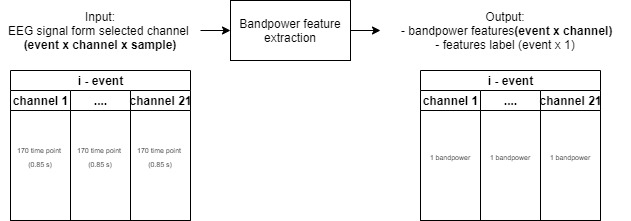

In [ ]:
from scipy.signal import welch
from scipy.integrate import simps

def bandpower(data, sf, band, window_sec, relative):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    #print(max())

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
def bandpower_extract (dataset, picks, band, window_sec, relative):

  """extract bandpower features of eeg signals using Welch method. 
    
    Parameters
    ----------
    dataset : mne epoch
        EEG epoch
    picks : list 
        list of EEG channels name
    band: int
        frequency range of bandpower features
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Returns
    ------
    features_dict : dictionary
        dictionary of 'data' --> bandpower features array
                      'label'--> data label
    """

  #get data EEG
  if picks is not None:
    data = dataset.get_data(picks=picks)
  else:
    data = dataset.get_data(picks='eeg')

  #get chnames
  chnames = dataset.ch_names

  #get class labels of EEG data
  labels= dataset.events[:,2]
  #labels= pd.get_dummies(labels).values.tolist()
  
  #make a feature dictionary
  features = []
  features_dict ={}
  for event in data:
    feature = []
    for channel in event:
       #compute bandpower feature for each channel
       feature.append(bandpower(channel, 200, band ,window_sec, relative))
    features.append(feature)
  #df_features = pd.DataFrame(features, columns=chnames[0:19])#
  features_dict['data'] = features
  features_dict['labels'] = labels
  return features_dict


##FTA features extraction

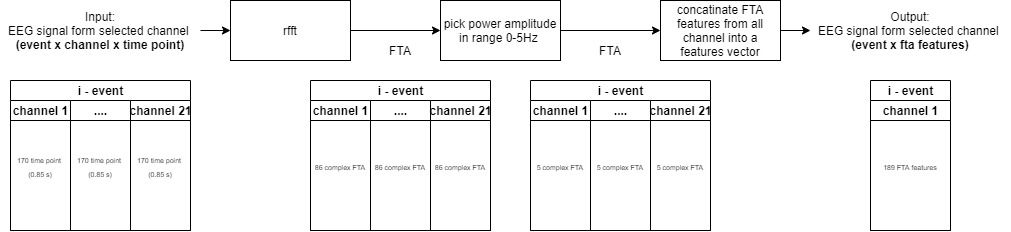

In [ ]:
def FTAfeatures(dataset, picks, lfreq, hfreq, method,lfreq2,hfreq2):

  """extract FTA features of eeg signals (REPLICATION OF MISCHENKO METHOD). 
    
    Parameters
    ----------
    dataset : mne epoch
        EEG epoch
    picks : list 
        list of EEG channels name
    lfreq and hfreq: int
        frequency of FTA features

    Returns
    ------
    features_dict : dictionary
        dictionary of 'data' --> FTA features array
                      'label'--> data label
    """

  features_dict ={}
                  
  if picks is not None:
    data = dataset.get_data(picks=picks)
  else:
    data = dataset.get_data(picks='eeg')

  #get class labels of EEG data
  labels= dataset.events[:,2]

  #get the frequency range (data length=170, sampfreq=200)
  freq = scipy.fft.rfftfreq(170, 1./200)

  features = []

  for trial in data:
    feature =[]
    for channel in trial:
      fta = scipy.fft.rfft(channel) # len 86
      #get fta in frequency frequency range: lfreq - hfreq
      band = fta[np.where((freq>=lfreq) & (freq<=hfreq))]
      output = getFeatureList(lfreq,hfreq,band,method=method)
      feature.extend(output)
      if (lfreq2 is not None) and (hfreq2 is not None):
        band2 = fta[np.where((freq>=lfreq2) & (freq<=hfreq2))]
        output2 = getFeatureList(lfreq2,hfreq2,band,method=method)
        feature.extend(output2)
    
    features.append(feature)
  
  #print('feature :', len(feature))
  #print('features :', len(features))
  if method == 'allStatistic':
    # fit scaler on training data
    norm = StandardScaler().fit(features)
    # transform training data
    features = norm.transform(features)
      
  features_dict['data'] = features
  features_dict['labels'] = labels

  return features_dict


In [ ]:
#FTAfeatures(dataset_list[0], None, lfreq=0, hfreq=5,method = 'allAmplitude',lfreq2=8,hfreq2=12)

In [ ]:
def getFeatureList (lfreq, hfreq,band,method):
  #all amplitude in band
  count = 0
  total_r =0
  total_i =0
  amplitude = []
  total_amp =[]
  maxmin=[]
  all_stat = []
  for i in band:
    if (count == 0) and (lfreq==0):
      # 0Hz dont have imaginary part
      amp_r =np.real(i)
      total_r = total_r + amp_r
      amplitude.append(amp_r)
    else:
      #real part give information about signal amplitude
      amp_r = np.real(i)
      amp_i = np.imag(i)
      total_r = total_r + amp_r
      total_i = total_i + amp_i
      amplitude.append(amp_r)
      #imaginary part give information about signal phase, phase =(arctan(imag/real))
      amplitude.append(amp_i)
    count = count +1
    #mean of signal amplitude
  mean = np.mean(np.abs(band))
  #maximum signal amplitude
  maxi = max(np.abs(band))
  #minimum signal amplitude
  mini = min(np.abs(band))
  #skewness of signal
  skew = scipy.stats.skew(np.abs(band))
  #signal kurtosis
  kurtosis = scipy.stats.kurtosis(np.abs(band))

  #total amplitude
  total_amp.append(total_r) 
  total_amp.append(total_i) 
  #use maximum and minimum amplitude as feature
  maxmin.append(maxi)
  maxmin.append(mini)
  #use all statistic properties
  all_stat.append(np.sum(np.abs(band)))
  all_stat.append(mean)
  all_stat.append(maxi)
  all_stat.append(mini)
  all_stat.append(skew)
  all_stat.append(kurtosis)

  if method == 'allAmplitude':
    return (amplitude)
  elif method == 'meanAmplitude':
    return ([mean])
  elif method == 'maxAmplitude':
    return ([maxi])
  elif method == 'minAmplitude':
    return ([mini])
  elif method == 'maxMin':
    return (maxmin)
  elif method == 'totalAmplitude':
    return (total_amp)
  elif method == 'allStatistic':
    return (all_stat)

##STFT

In [ ]:
def STFTfeatures(dataset, picks, lfreq, hfreq, lfreq2, hfreq2):

  """extract STFT features of eeg signals. 
    
    Parameters
    ----------
    dataset : mne epoch
        EEG epoch
    picks : list 
        list of EEG channels name
    lfreq and hfreq: int
        frequency of FTA features

    Returns
    ------
    features_dict : dictionary
        dictionary of 'data' --> FTA features array
                      'label'--> data label
    """

  features_dict ={}
                  
  if picks is not None:
    data = dataset.get_data(picks=picks)
  else:
    data = dataset.get_data(picks='eeg')

  #get class labels of EEG data
  labels= dataset.events[:,2]

  features = []

  for trial in data:
    feature = []

    for channel in trial:
      f,t,zxx= scipy.signal.stft(channel,nperseg=9,noverlap=4, fs=200) 
      #get fta in frequency frequency range: lfreq - hfreq
    
      band = zxx[np.where((f>=lfreq) & (f<=hfreq))]
      #print(f)
      for i in band:
        feature.extend(np.real(i))
        feature.extend(np.imag(i))
      if (lfreq2 is not None) and (hfreq2 is not None):
        band2 = zxx[np.where((f>=lfreq2) & (f<=hfreq2))]
        for i in band2:
          feature.extend(np.real(i))
          feature.extend(np.imag(i))
    
    features.append(feature)

  features_dict['data'] = features 
  features_dict['labels'] = labels

  return features_dict




# SVM CLASSIFIER

kernel = linear or rbf 

validation = 10-fold cross validation (test size:0.27)



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import KFold

def SVMclassifier(features, SVMkernel, split, nfold, Confusion=False):

  """Classify EEG features using SVM.SVC and validate the result using n-fold cross validation. 
    
    Parameters
    ----------
    features : float
        EEG features in dictionary format

    Returns
    ------
    accuracy : float
        accuracy of each fold validation
    mean_acc : float
        mean off all fold accuracy
    """

  #assign data
  data = features['data']
  #print(data[1])
  #assign label
  label = features['labels']
  
  #Create a svm Classifier
  clf = svm.SVC(kernel= SVMkernel) #,C=0.1,gamma=1

  if Confusion == True:
  
    conf_matrix_list_of_arrays = []
    kf = KFold(nfold)

    for train_index, test_index in kf.split(data):

      X_train, X_test = np.array(data)[train_index], np.array(data)[test_index]
      y_train, y_test = label[train_index], label[test_index]

      clf.fit(X_train, y_train)
      conf_matrix = confusion_matrix(y_test, clf.predict(X_test),normalize='true')
      conf_matrix_list_of_arrays .append(conf_matrix)
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
    print(np.round(mean_of_conf_matrix_arrays,2))

    '''# Plot normalized confusion matrix
    plt.figure()
    classes_names = ['thumb','index','middle','ring','pinky']
    plot_confusion_matrix(mean_of_conf_matrix_arrays, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')'''

  # Model Accuracy
  accuracy = cross_val_score(clf, data, label, cv=nfold)
  mean_acc = np.mean(accuracy)
  return accuracy,mean_acc

In [ ]:
#features =FTAfeatures(dataset_list[0],None,lfreq=0,hfreq=5,lfreq2=8,hfreq2=12,method='allAmplitude')
#tunning(features)

# MAIN PROGRAM

In [ ]:
def mainProgram(channel_selection,features_extraction, SVMkernel, 
                n_chan = 1, n_chan_perclass=1, manual_subset = ['C3','Cz','C4'],
                band = (0,5), window_sec=0.85, relative=False, max_acc_decrease = 0.02,
                FTA_lfreq = 0,FTA_hfreq = 5, FTAmethod='allAmplitude',FTA_lfreq2 = None,FTA_hfreq2 = None,
                split = 0.27, nfold = 10,Confusions=False):

  sum =0
  subj_accuracy = []
  features = {}
  subset = []
  n_selected = []
  rank_perclass_all = {}
  modus_dict = {}
  modus_perclass = {}

  for subject,title in zip(dataset_list,list_title):
    rank_perclass = {}
    print(title)
    
    #Choose channels selection method
    if channel_selection is None:
      print("Use all EEG channels")
      subset = None
      #Choose features extraction method
      if features_extraction == 'FTA':
        features =FTAfeatures(subject,subset,FTA_lfreq,FTA_hfreq,FTAmethod,FTA_lfreq2,FTA_hfreq2)
      elif features_extraction == 'STFT':
        features =STFTfeatures(subject,subset,lfreq=FTA_lfreq,hfreq=FTA_hfreq,lfreq2=FTA_lfreq2,hfreq2=FTA_hfreq2)
      elif features_extraction == 'BandPower':
        features = bandpower_extract(subject,subset,band, window_sec, relative)

      #Classification
      acc, mean_acc =  SVMclassifier(features, SVMkernel, split, nfold,Confusion=Confusions)
      subj_accuracy.append(mean_acc)
      print("Accuracy per fold:",np.round(acc,3))
      print("Mean of Subject accuracy: ", np.round(mean_acc,3))
      sum = sum + acc
      print("\n")

    elif channel_selection == 'multiclassCSP':
      #get spatial pattern
      SF_dict,CSP_dict = CSP(subject)
      #rank channel contribution score
      rank_perclass, rank_all = channelRank(CSP_dict, subject, n_chan_perclass)
      print('Most used channel in all trial: \n', rank_all)
      print('Relevan channels in each class: \n',rank_perclass)
      accuracyLost= sequentialSearching(subject=subject, channelScore=rank_all,SVMkernel=SVMkernel,
                                       features_extraction=features_extraction,
                                       FTA_lfreq=FTA_lfreq, FTA_hfreq=FTA_hfreq,FTA_lfreq2=FTA_lfreq2, 
                                       FTA_hfreq2=FTA_hfreq2, FTAmethod=FTAmethod,
                                       split=split, nfold=nfold)

      opt_acc, opt_nchan = plotAccuracyLost (accuracyLost,max_acc_decrease)
      subj_accuracy.append(opt_acc)
      n_selected.append(opt_nchan)
      #count modus for all subject
      kanal = list(map(itemgetter(0),rank_all))
      modus = list(map(itemgetter(1),rank_all))
      for i in range(len(kanal)):
        if kanal[i] not in modus_dict:
          modus_dict[kanal[i]] = modus[i]
        else:
          modus_dict[kanal[i]] += modus[i]

      


    elif channel_selection == 'PCA':
      rank_all,rank_perclass = pca_eeg (subject, n_chan=n_chan, n_chan_perclass=n_chan_perclass)
      print('Most used channel in all trial: \n', rank_all)
      print('Relevan channels in each class: \n',rank_perclass)
      accuracyLost= sequentialSearching(subject=subject, channelScore=rank_all,SVMkernel=SVMkernel, 
                                       features_extraction=features_extraction,
                                       FTA_lfreq=FTA_lfreq, FTA_hfreq=FTA_hfreq,FTA_lfreq2=FTA_lfreq2, 
                                       FTA_hfreq2=FTA_hfreq2, FTAmethod=FTAmethod,
                                       split=split, nfold=nfold) #, acc, mean_acc 
      opt_acc, opt_nchan = plotAccuracyLost (accuracyLost,max_acc_decrease)
      subj_accuracy.append(opt_acc)
      n_selected.append(opt_nchan)

      #count modus for all subject
      kanal = list(map(itemgetter(0),rank_all))
      modus = list(map(itemgetter(1),rank_all))
      for i in range(len(kanal)):
        if kanal[i] not in modus_dict:
          modus_dict[kanal[i]] = modus[i]
        else:
          modus_dict[kanal[i]] += modus[i]


    elif channel_selection == 'manual':
      subset = manual_subset
      print("Use {}".format(subset))
      #Choose features extraction method
      if features_extraction == 'FTA':
        features =FTAfeatures(subject,subset,FTA_lfreq,FTA_hfreq,FTAmethod,FTA_lfreq2,FTA_hfreq2)
      elif features_extraction == 'STFT':
        features =STFTfeatures(subject,subset,FTA_lfreq,FTA_hfreq,FTA_lfreq2,FTA_hfreq2)
      elif features_extraction == 'BandPower':
        features = bandpower_extract(subject,subset,band, window_sec, relative)
      #Classification
      acc, mean_acc =  SVMclassifier(features, SVMkernel, split, nfold)
      subj_accuracy.append(mean_acc)
      print("Accuracy per fold:",np.round(acc,3))
      print("Mean of Subject accuracy: ", np.round(mean_acc,3))
      sum = sum + acc
      print("\n")
   

  #each fold mean accuracy
  mean_fold_accuracy = sum/len(dataset_list)

  #print accuracy
  if (channel_selection is None) or (channel_selection == 'manual'):
    print("mean : ",np.round(mean_fold_accuracy,3) , "\n")
  else:
    print('mean of selected channel number :', round(np.mean(n_selected)))
    print('relevan channel in all subject (modus) : \n',sorted(modus_dict.items(), key=lambda item: item[1], reverse=True))

  print("mean of all subject accuracy: ", np.round(np.mean(subj_accuracy),3))


  return np.mean(subj_accuracy)

# RESULT

### Sequential Searching test

In [ ]:
channel_selection = 'PCA'
n_chan=1
n_chan_perclass=3
max_acc_decrease =0.02

rank_all,rank_perclass = pca_eeg (dataset_list[0], n_chan=n_chan, n_chan_perclass=n_chan_perclass)
print('Most used channel in all trial: \n', rank_all)
print('Relevan channels in each class: \n',rank_perclass)
accuracyLost= sequentialSearching(subject=dataset_list[0], channelScore=rank_all,SVMkernel='rbf', 
                                  features_extraction='FTA',
                                  FTA_lfreq=0, FTA_hfreq=5,FTA_lfreq2=None, FTA_hfreq2=None,
                                  FTAmethod='allAmplitude',
                                  split=0.27, nfold=10) #, acc, mean_acc 
print('accuracyLost :',accuracyLost)
opt_acc, opt_nchan = plotAccuracyLost (accuracyLost,max_acc_decrease)

In [ ]:
n_chan=1
n_chan_perclass=3
max_acc_decrease =0.02

#get spatial pattern
SP_dict,CSP_dict = CSP(dataset_list[0])
#rank channel contribution score
rank_perclass, rank_all = channelRank(CSP_dict, subject, n_chan_perclass)

print('Most used channel in all trial: \n', rank_all)
print('Relevan channels in each class: \n',rank_perclass)
accuracyLost= sequentialSearching(subject=dataset_list[0], channelScore=rank_all,SVMkernel='rbf', 
                                  features_extraction='FTA',
                                  FTA_lfreq=0, FTA_hfreq=5,FTA_lfreq2=None, FTA_hfreq2=None,
                                  FTAmethod='allAmplitude',
                                  split=0.27, nfold=10) #, acc, mean_acc 
print('accuracyLost :',accuracyLost)
opt_acc, opt_nchan = plotAccuracyLost (accuracyLost,max_acc_decrease)

##No channels selection

###FTA MRCP 'allAmplitude', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10,Confusions=False)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.312 0.365 0.438 0.479 0.406 0.448 0.281 0.375 0.389 0.421]
Mean of Subject accuracy:  0.391


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.469 0.531 0.531 0.49  0.479 0.604 0.479 0.479 0.5   0.495]
Mean of Subject accuracy:  0.506


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.656 0.625 0.615 0.719 0.583 0.594 0.51  0.521 0.663 0.505]
Mean of Subject accuracy:  0.599


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.552 0.583 0.573 0.521 0.552 0.583 0.573 0.604 0.698 0.579]
Mean of Subject accuracy:  0.582


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.417 0.365 0.292 0.271 0.281 0.323 0.271 0.337 0.421 0.4  ]
Mean of Subject accuracy:  0.338


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.406 0.271 0.323 0.281 0.26  0.344 0.284 0.347 0.379 0.358]
Mean of Subject accuracy:  0.325


SubjectA-160408-epo.fif
Use all EE

### FTA MRCP 'Allstat', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allStatistic',
                       SVMkernel='rbf', split=0.27, nfold=10,Confusions=False)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.281 0.219 0.271 0.24  0.292 0.219 0.26  0.25  0.2   0.158]
Mean of Subject accuracy:  0.239


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.292 0.292 0.312 0.354 0.375 0.375 0.417 0.396 0.292 0.284]
Mean of Subject accuracy:  0.339


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.469 0.469 0.417 0.479 0.365 0.375 0.344 0.281 0.263 0.316]
Mean of Subject accuracy:  0.378


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.365 0.396 0.396 0.354 0.344 0.344 0.354 0.406 0.396 0.495]
Mean of Subject accuracy:  0.385


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.25  0.24  0.219 0.219 0.25  0.188 0.208 0.179 0.189 0.263]
Mean of Subject accuracy:  0.22


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.219 0.198 0.198 0.26  0.292 0.292 0.2   0.168 0.211 0.253]
Mean of Subject accuracy:  0.229


SubjectA-160408-epo.fif
Use all EEG

###FTA MRCP 'mean', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTAmethod='meanAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.281 0.229 0.198 0.188 0.302 0.25  0.281 0.24  0.253 0.295]
Mean of Subject accuracy:  0.252


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.26  0.354 0.24  0.365 0.333 0.448 0.312 0.385 0.354 0.316]
Mean of Subject accuracy:  0.337


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.385 0.385 0.333 0.417 0.333 0.281 0.354 0.354 0.305 0.368]
Mean of Subject accuracy:  0.352


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.385 0.417 0.417 0.375 0.333 0.385 0.375 0.406 0.417 0.463]
Mean of Subject accuracy:  0.397


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.219 0.26  0.229 0.24  0.24  0.188 0.24  0.221 0.284 0.284]
Mean of Subject accuracy:  0.24


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.135 0.208 0.177 0.229 0.198 0.25  0.242 0.189 0.179 0.2  ]
Mean of Subject accuracy:  0.201


SubjectA-160408-epo.fif
Use all EEG

###FTA MRCP 'max', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTAmethod='maxAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.177 0.24  0.156 0.208 0.177 0.26  0.198 0.198 0.274 0.221]
Mean of Subject accuracy:  0.211


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.281 0.365 0.281 0.354 0.344 0.375 0.385 0.417 0.26  0.232]
Mean of Subject accuracy:  0.329


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.375 0.406 0.302 0.469 0.333 0.365 0.323 0.292 0.326 0.337]
Mean of Subject accuracy:  0.353


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.344 0.302 0.323 0.312 0.396 0.396 0.354 0.323 0.438 0.453]
Mean of Subject accuracy:  0.364


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.208 0.25  0.229 0.198 0.188 0.188 0.219 0.232 0.2   0.232]
Mean of Subject accuracy:  0.214


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.188 0.198 0.24  0.177 0.198 0.25  0.253 0.221 0.211 0.242]
Mean of Subject accuracy:  0.218


SubjectA-160408-epo.fif
Use all EE

###FTA MRCP 'min', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTAmethod='minAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.208 0.26  0.25  0.229 0.229 0.292 0.208 0.188 0.232 0.211]
Mean of Subject accuracy:  0.231


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.24  0.135 0.302 0.292 0.281 0.312 0.302 0.312 0.229 0.189]
Mean of Subject accuracy:  0.26


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.229 0.198 0.24  0.333 0.312 0.323 0.229 0.146 0.305 0.221]
Mean of Subject accuracy:  0.254


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.24  0.229 0.312 0.271 0.333 0.312 0.26  0.26  0.281 0.347]
Mean of Subject accuracy:  0.285


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.188 0.24  0.167 0.208 0.188 0.25  0.177 0.211 0.274 0.158]
Mean of Subject accuracy:  0.206


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.135 0.167 0.208 0.156 0.198 0.25  0.242 0.189 0.211 0.263]
Mean of Subject accuracy:  0.202


SubjectA-160408-epo.fif
Use all EEG

###FTA MRCP 'maxMin', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTAmethod='maxMin',
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.208 0.229 0.188 0.24  0.198 0.271 0.229 0.198 0.274 0.221]
Mean of Subject accuracy:  0.226


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.25  0.354 0.281 0.375 0.323 0.375 0.406 0.438 0.271 0.274]
Mean of Subject accuracy:  0.335


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.375 0.396 0.312 0.458 0.365 0.312 0.323 0.281 0.337 0.347]
Mean of Subject accuracy:  0.351


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.292 0.344 0.365 0.333 0.365 0.375 0.323 0.323 0.417 0.505]
Mean of Subject accuracy:  0.364


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.229 0.24  0.24  0.188 0.208 0.177 0.198 0.221 0.232 0.221]
Mean of Subject accuracy:  0.215


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.167 0.167 0.229 0.188 0.208 0.25  0.242 0.2   0.2   0.221]
Mean of Subject accuracy:  0.207


SubjectA-160408-epo.fif
Use all EE

###FTA MRCP 'total', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTAmethod='totalAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.344 0.229 0.344 0.302 0.271 0.292 0.167 0.26  0.242 0.263]
Mean of Subject accuracy:  0.271


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.344 0.406 0.354 0.427 0.375 0.396 0.385 0.427 0.344 0.411]
Mean of Subject accuracy:  0.387


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.396 0.406 0.302 0.354 0.302 0.365 0.385 0.281 0.316 0.316]
Mean of Subject accuracy:  0.342


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.396 0.479 0.385 0.458 0.469 0.458 0.458 0.49  0.542 0.568]
Mean of Subject accuracy:  0.47


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.281 0.24  0.198 0.26  0.24  0.198 0.188 0.253 0.211 0.189]
Mean of Subject accuracy:  0.226


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.312 0.219 0.26  0.219 0.229 0.198 0.211 0.263 0.221 0.242]
Mean of Subject accuracy:  0.237


SubjectA-160408-epo.fif
Use all EEG

###bandpwer MRCP, SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='BandPower', band=(0,5), window_sec=0.85, relative=False,
                       SVMkernel='rbf', split=0.27, nfold=10)

###FTA alpha 'allAmplitude', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=8, FTA_hfreq=12, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

###FTA beta 'allAmplitude', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=13, FTA_hfreq=30, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

###STFT MRCP, SVM linear and rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='STFT', FTA_lfreq=0, FTA_hfreq=5,
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.333 0.479 0.458 0.469 0.469 0.438 0.344 0.427 0.463 0.432]
Mean of Subject accuracy:  0.431


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.521 0.562 0.562 0.49  0.542 0.615 0.51  0.51  0.531 0.547]
Mean of Subject accuracy:  0.539


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.635 0.615 0.604 0.74  0.635 0.594 0.542 0.604 0.621 0.589]
Mean of Subject accuracy:  0.618


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.562 0.552 0.552 0.583 0.625 0.573 0.646 0.594 0.677 0.568]
Mean of Subject accuracy:  0.593


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.427 0.385 0.354 0.302 0.333 0.406 0.323 0.432 0.453 0.442]
Mean of Subject accuracy:  0.386


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.365 0.365 0.333 0.323 0.26  0.365 0.379 0.326 0.379 0.316]
Mean of Subject accuracy:  0.341


SubjectA-160408-epo.fif
Use all EE

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='STFT', FTA_lfreq=8, FTA_hfreq=12,FTA_lfreq2=None, FTA_hfreq2=None,
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectB-160316-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectC-151204-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectA-160405-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectF-151027-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(861, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(861, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(861, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectF-160209-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectA-160408-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(780, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(780, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(780, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectI-160719-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(863, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectH-160804-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(828, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(829, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(829, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectF-160210-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectG-160413-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(849, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(849, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(849, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectB-160311-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectB-160309-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(841, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(841, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(841, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectC-160429-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(846, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(846, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(846, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectE-160321-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(860, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectE-160429-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(851, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(851, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(851, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectE-160415-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(851, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(851, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(851, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectI-160723-epo.fif
Use all EEG channels


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(862, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


SubjectG-160428-epo.fif
Use all EEG channels
Accuracy per fold: [nan nan nan nan nan nan nan nan nan nan]
Mean of Subject accuracy:  nan


mean :  [nan nan nan nan nan nan nan nan nan nan] 

mean of all subject accuracy:  nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(859, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(859, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with 0 feature(s) (shape=(859, 0)) while a minimum of 1 is required.

  FitFailedWarning)
/usr/local/lib/pyth

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='STFT', FTA_lfreq=13, FTA_hfreq=30,
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.323 0.479 0.469 0.438 0.458 0.417 0.333 0.417 0.421 0.389]
Mean of Subject accuracy:  0.414


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.5   0.573 0.573 0.51  0.51  0.625 0.542 0.542 0.583 0.526]
Mean of Subject accuracy:  0.548


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.635 0.562 0.625 0.719 0.646 0.604 0.573 0.594 0.589 0.579]
Mean of Subject accuracy:  0.613


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.562 0.562 0.51  0.562 0.604 0.604 0.615 0.625 0.615 0.621]
Mean of Subject accuracy:  0.588


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.417 0.385 0.365 0.323 0.344 0.417 0.344 0.389 0.463 0.421]
Mean of Subject accuracy:  0.387


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.344 0.302 0.229 0.354 0.25  0.312 0.274 0.284 0.379 0.284]
Mean of Subject accuracy:  0.301


SubjectA-160408-epo.fif
Use all EE

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='STFT', FTA_lfreq=0, FTA_hfreq=30,
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use all EEG channels
Accuracy per fold: [0.344 0.479 0.448 0.469 0.479 0.427 0.333 0.417 0.463 0.453]
Mean of Subject accuracy:  0.431


SubjectB-160316-epo.fif
Use all EEG channels
Accuracy per fold: [0.521 0.583 0.573 0.49  0.542 0.615 0.51  0.531 0.542 0.537]
Mean of Subject accuracy:  0.544


SubjectC-151204-epo.fif
Use all EEG channels
Accuracy per fold: [0.635 0.604 0.615 0.729 0.635 0.583 0.552 0.615 0.621 0.6  ]
Mean of Subject accuracy:  0.619


SubjectA-160405-epo.fif
Use all EEG channels
Accuracy per fold: [0.583 0.552 0.562 0.562 0.625 0.594 0.646 0.604 0.667 0.579]
Mean of Subject accuracy:  0.597


SubjectF-151027-epo.fif
Use all EEG channels
Accuracy per fold: [0.427 0.365 0.385 0.302 0.323 0.417 0.323 0.432 0.442 0.432]
Mean of Subject accuracy:  0.385


SubjectF-160209-epo.fif
Use all EEG channels
Accuracy per fold: [0.365 0.354 0.312 0.333 0.24  0.333 0.316 0.305 0.411 0.263]
Mean of Subject accuracy:  0.323


SubjectA-160408-epo.fif
Use all EE

###FTA Combination of MRCP, alpha, and beta 'all Amplitude', SVM rbf

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTA_lfreq2=8, FTA_hfreq2=12, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTA_lfreq2=13, FTA_hfreq2=30, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

In [ ]:
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5,FTA_lfreq2=8, FTA_hfreq2=30, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

##multiclass CSP channels selection

###FTA MRCP 'allAmplitude', SVM rbf

SubjectB-151110-epo.fif
Most used channel in all trial: 
 [('Fp1', 3), ('T6', 2), ('Fp2', 2), ('Cz', 2), ('P3', 1), ('C4', 1), ('C3', 1), ('O1', 1), ('T4', 1), ('F8', 1)]
Relevan channels in each class: 
 {'thumb': [(0.21747331645576767, 'T6'), (0.12472630834483556, 'P3'), (0.08003905096586807, 'Fp1')], 'index': [(0.278052196358776, 'Fp1'), (0.2060599825123729, 'Fp2'), (0.11269909941427801, 'C4')], 'middle': [(0.23934406255216448, 'T6'), (0.08760961460425165, 'Fp1'), (0.08073663471817925, 'C3')], 'ring': [(0.24628561911147456, 'Cz'), (0.14497191052287514, 'O1'), (0.1435307192382888, 'T4')], 'pinky': [(0.18777286506954677, 'F8'), (0.167418632428763, 'Cz'), (0.1234693161034423, 'Fp2')]}
dropped channel  T4
dropped channel  F8
dropped channel  C4
dropped channel  O1
dropped channel  C3
dropped channel  P3
dropped channel  Cz
dropped channel  Fp2
dropped channel  T6


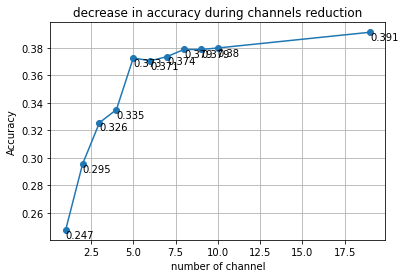

candidate of best selected channel:  [(10, 0.3800109649122807), (9, 0.3789035087719298), (8, 0.3789364035087719), (7, 0.37373903508771933), (5, 0.37276315789473685)]
maximum accuracy is 0.37 with 5 channel(s)


SubjectB-160316-epo.fif
Most used channel in all trial: 
 [('Cz', 4), ('O1', 4), ('T6', 2), ('F8', 1), ('O2', 1), ('T5', 1), ('Fp1', 1), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [(0.356501601698183, 'Cz'), (0.26534835592052947, 'T6'), (0.2548188396670097, 'O1')], 'index': [(0.28928263278204025, 'Cz'), (0.2439110454893447, 'O1'), (0.22754041124320454, 'F8')], 'middle': [(0.26789419752073196, 'T6'), (0.2561494406350111, 'Cz'), (0.19867974670847371, 'O2')], 'ring': [(0.3653387597532422, 'Cz'), (0.25588019123925465, 'O1'), (0.23836969309669997, 'T5')], 'pinky': [(0.28965890465236227, 'O1'), (0.2874888959067925, 'Fp1'), (0.22362412120904235, 'F7')]}
dropped channel  Fp1
dropped channel  T5
dropped channel  O2
dropped channel  F8
dropped channel  F7
dropped channel  T6
d

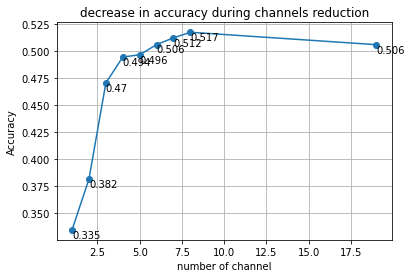

candidate of best selected channel:  [(8, 0.5172039473684211), (7, 0.5120504385964912), (6, 0.5057894736842105), (5, 0.4964144736842105), (4, 0.4943092105263158)]
maximum accuracy is 0.49 with 4 channel(s)


SubjectC-151204-epo.fif
Most used channel in all trial: 
 [('Fp1', 3), ('Fp2', 2), ('O2', 2), ('Cz', 2), ('Fz', 2), ('F8', 1), ('F4', 1), ('C3', 1), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [(0.32349090204462927, 'Fp1'), (0.13816654232779133, 'F8'), (0.12579640500169847, 'F4')], 'index': [(0.22042464499938402, 'Fp2'), (0.18317954211401732, 'C3'), (0.15562722408577767, 'O2')], 'middle': [(0.5533399887807173, 'Fp2'), (0.4930433736440242, 'Fp1'), (0.3199978308832963, 'T5')], 'ring': [(0.22532570851866984, 'Cz'), (0.18212905759459286, 'Fz'), (0.1658527260689316, 'O2')], 'pinky': [(0.3799234227392033, 'Fp1'), (0.19059143944415388, 'Fz'), (0.18681536851388686, 'Cz')]}
dropped channel  C3
dropped channel  F4
dropped channel  F8
dropped channel  T5
dropped channel  Fz
dropped

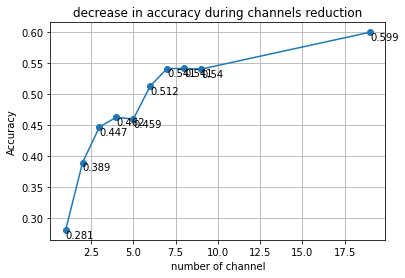

candidate of best selected channel:  []
maximum accuracy is 0.54 with 8 channel(s)


SubjectA-160405-epo.fif
Most used channel in all trial: 
 [('F8', 4), ('Fp1', 3), ('F7', 3), ('Fp2', 1), ('O2', 1), ('T5', 1), ('O1', 1), ('F3', 1)]
Relevan channels in each class: 
 {'thumb': [(0.4987734193739611, 'F8'), (0.4286773362814273, 'Fp2'), (0.22616676106389094, 'Fp1')], 'index': [(0.38754371148845174, 'F7'), (0.32334993271432966, 'Fp1'), (0.2154579569197585, 'F8')], 'middle': [(0.2710235819852041, 'F8'), (0.20842975187146434, 'O2'), (0.19572007741711014, 'T5')], 'ring': [(0.2629555142312519, 'F7'), (0.2057104229609033, 'F8'), (0.17708877764478304, 'O1')], 'pinky': [(0.46689764480915885, 'F7'), (0.4209174295395806, 'Fp1'), (0.21625514643969038, 'F3')]}
dropped channel  F3
dropped channel  O1
dropped channel  O2
dropped channel  Fp2
dropped channel  T5
dropped channel  Fp1
dropped channel  F7


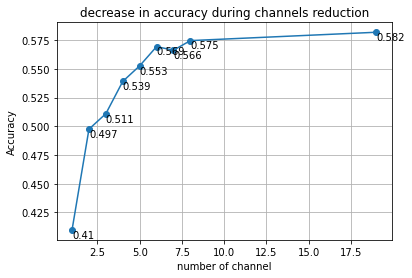

candidate of best selected channel:  [(8, 0.5745833333333332), (7, 0.5662171052631579), (6, 0.5693421052631579)]
maximum accuracy is 0.57 with 6 channel(s)


SubjectF-151027-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('Cz', 2), ('Pz', 2), ('C3', 1), ('O2', 1), ('F4', 1), ('C4', 1), ('Fz', 1), ('O1', 1), ('P4', 1), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [(0.28107372635323913, 'Cz'), (0.2785671392813082, 'Pz'), (0.26421766152100123, 'F8')], 'index': [(0.1501583992639608, 'C3'), (0.1468505199821535, 'Pz'), (0.10725620864048337, 'O2')], 'middle': [(0.2917031113160073, 'F4'), (0.1709239026280069, 'C4'), (0.16865073211926138, 'F8')], 'ring': [(0.14889360511657151, 'Fz'), (0.12476828929148345, 'O1'), (0.10147648720903753, 'F8')], 'pinky': [(0.21629378979713604, 'P4'), (0.19402747967855344, 'Cz'), (0.18555584416496662, 'T5')]}
dropped channel  Fz
dropped channel  P4
dropped channel  C3
dropped channel  C4
dropped channel  O2
dropped channel  O1
dropped channel  F4
dr

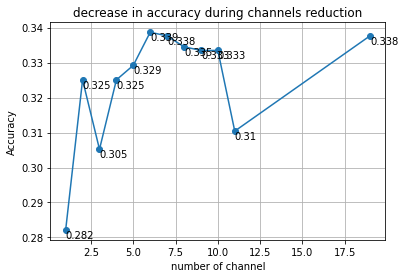

candidate of best selected channel:  [(10, 0.3334758771929825), (9, 0.33348684210526314), (8, 0.3345175438596491), (7, 0.3376315789473684), (6, 0.3386842105263158), (5, 0.32922149122807015), (4, 0.32506578947368425), (2, 0.3250657894736842)]
maximum accuracy is 0.33 with 2 channel(s)


SubjectF-160209-epo.fif
Most used channel in all trial: 
 [('Fp2', 2), ('O1', 2), ('F3', 2), ('Fp1', 1), ('O2', 1), ('T6', 1), ('T5', 1), ('Pz', 1), ('C4', 1), ('P4', 1), ('F8', 1), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [(0.23089476260879438, 'Fp1'), (0.2104546336819581, 'Fp2'), (0.14588642454983786, 'O1')], 'index': [(0.1656010894698798, 'O2'), (0.09851249430633616, 'T6'), (0.07950932792082774, 'T5')], 'middle': [(0.12151387955838083, 'Pz'), (0.09904971765742604, 'Fp2'), (0.054647603112557466, 'C4')], 'ring': [(0.0673208879964183, 'P4'), (0.024629359432332354, 'F3'), (0.022611732237013984, 'F8')], 'pinky': [(0.223569684886791, 'F7'), (0.12738216231610622, 'F3'), (0.11596145130696214, 'O

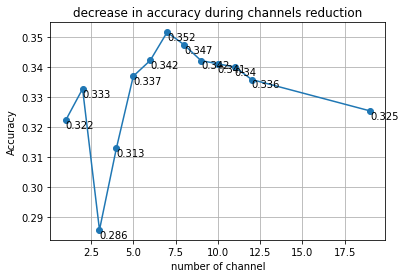

candidate of best selected channel:  [(12, 0.3358333333333333), (11, 0.3400109649122807), (10, 0.3410526315789474), (9, 0.3421491228070175), (8, 0.34742324561403504), (7, 0.35157894736842105), (6, 0.34218201754385963), (5, 0.3369517543859649), (4, 0.3129495614035088), (2, 0.332719298245614), (1, 0.32223684210526315)]
maximum accuracy is 0.32 with 1 channel(s)


SubjectA-160408-epo.fif
Most used channel in all trial: 
 [('O1', 3), ('Fp1', 3), ('O2', 2), ('Fp2', 2), ('F8', 2), ('F7', 1), ('T3', 1), ('T4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.31242862435310054, 'O1'), (0.08650693685928179, 'O2'), (0.056176175521654645, 'Fp2')], 'index': [(0.2553927491555274, 'F7'), (0.167638182913324, 'O2'), (0.16523702241505417, 'Fp1')], 'middle': [(0.2671191801347943, 'O1'), (0.105673565070283, 'F8'), (0.08447593608615181, 'T3')], 'ring': [(0.2541048304746475, 'Fp1'), (0.10294903539644013, 'F8'), (0.06626436412996084, 'Fp2')], 'pinky': [(0.19626358674648542, 'O1'), (0.1287037543849978, 'F

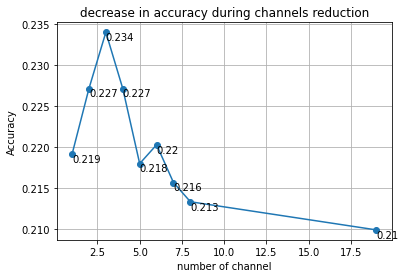

candidate of best selected channel:  [(8, 0.21332531408714245), (7, 0.21566426089280938), (6, 0.22027532745255277), (5, 0.21797647687784014), (4, 0.22713178294573644), (3, 0.23400160384923815), (2, 0.22713178294573644), (1, 0.21911253675487838)]
maximum accuracy is 0.22 with 1 channel(s)


SubjectI-160719-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 3), ('Fp2', 2), ('O1', 2), ('T3', 1), ('Pz', 1), ('F3', 1), ('O2', 1), ('Fp1', 1)]
Relevan channels in each class: 
 {'thumb': [(0.40973545891455604, 'F8'), (0.28764461304191435, 'F7'), (0.20573403191012613, 'Fp2')], 'index': [(0.4634279831099534, 'F7'), (0.2515638190874797, 'F8'), (0.17281532293818833, 'T3')], 'middle': [(0.14368433423207294, 'O1'), (0.1251313735776284, 'Pz'), (0.10468224153384677, 'F3')], 'ring': [(0.1574806270199648, 'O2'), (0.11203514020251315, 'O1'), (0.05984482753155873, 'Fp2')], 'pinky': [(0.46875740569636726, 'F7'), (0.2708662041557888, 'F8'), (0.22061579510195486, 'Fp1')]}
dropped channel  Fp1
dropp

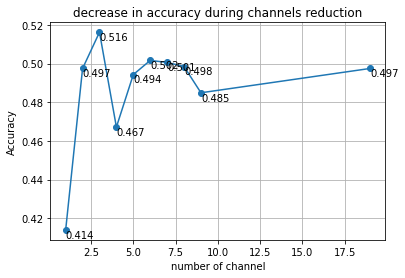

candidate of best selected channel:  [(9, 0.4848793859649122), (8, 0.4984539473684211), (7, 0.5005701754385965), (6, 0.5016008771929825), (5, 0.4942872807017544), (3, 0.516173245614035), (2, 0.4974342105263158)]
maximum accuracy is 0.5 with 2 channel(s)


SubjectH-160804-epo.fif
Most used channel in all trial: 
 [('Pz', 2), ('F8', 2), ('Fp2', 2), ('F7', 2), ('F4', 1), ('P3', 1), ('O1', 1), ('O2', 1), ('T6', 1), ('Fp1', 1), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [(0.18904268548348288, 'Pz'), (0.14276768732860168, 'F8'), (0.09847988497465486, 'F4')], 'index': [(0.13937522452692502, 'P3'), (0.10970595536813421, 'O1'), (0.06279404623609679, 'O2')], 'middle': [(0.16889776049522054, 'T6'), (0.1424813640527696, 'Fp2'), (0.12634607871496856, 'Fp1')], 'ring': [(0.18397850292404233, 'T5'), (0.15367391446505713, 'F7'), (0.10839586852126559, 'Pz')], 'pinky': [(0.288242668898849, 'F8'), (0.2813519085959971, 'F7'), (0.22311983726506146, 'Fp2')]}
dropped channel  Fp1
dropped channel  

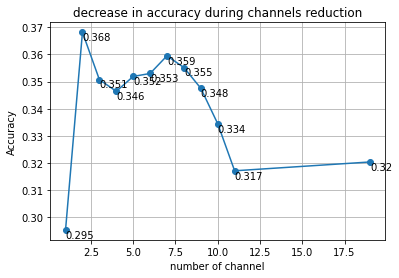

candidate of best selected channel:  [(11, 0.3171341748480598), (10, 0.3344670406732118), (9, 0.34751051893408136), (8, 0.3551309022907901), (7, 0.3594670406732118), (6, 0.3529569892473118), (5, 0.3518700327255727), (4, 0.3463884992987377), (3, 0.3507129499766246), (2, 0.36813931743805517)]
maximum accuracy is 0.37 with 2 channel(s)


SubjectF-160210-epo.fif
Most used channel in all trial: 
 [('F7', 4), ('Pz', 2), ('Fp2', 2), ('O1', 2), ('F8', 2), ('Fp1', 1), ('O2', 1), ('F4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.23403792865153802, 'Pz'), (0.18768532975438013, 'Fp2'), (0.16427307026864324, 'F7')], 'index': [(0.19036218911006095, 'F7'), (0.1666917591981244, 'O1'), (0.14914219545032079, 'F8')], 'middle': [(0.19627079583204038, 'F7'), (0.1087371153061516, 'Fp1'), (0.10545621891727608, 'O2')], 'ring': [(0.20722770115711445, 'F4'), (0.12452872452301605, 'Fp2'), (0.10340625444861853, 'F8')], 'pinky': [(0.19529347020909826, 'O1'), (0.1516144891569181, 'F7'), (0.1269599555940965

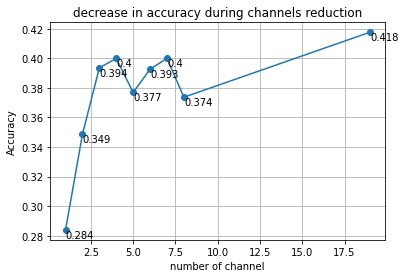

candidate of best selected channel:  [(7, 0.3999232456140351), (4, 0.3998684210526316)]
maximum accuracy is 0.4 with 4 channel(s)


SubjectG-160413-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 2), ('Fp2', 2), ('Fp1', 2), ('Cz', 1), ('O2', 1), ('T6', 1), ('P3', 1), ('F3', 1), ('Fz', 1)]
Relevan channels in each class: 
 {'thumb': [(0.12078032935832425, 'F8'), (0.12051623211117635, 'F7'), (0.08450668893466706, 'Cz')], 'index': [(0.19569554300247097, 'Fp2'), (0.07707917100618578, 'Fp1'), (0.03651806101669608, 'F8')], 'middle': [(0.17238037401854023, 'O2'), (0.06295091119466975, 'T6'), (0.050291217845544176, 'Fp1')], 'ring': [(0.12017801240820447, 'P3'), (0.015158501784764413, 'Fp2'), (0.01500262437823527, 'F3')], 'pinky': [(0.22593406362161877, 'Fz'), (0.04370170959910765, 'F7'), (0.03941408232690866, 'F8')]}
dropped channel  F3
dropped channel  Fz
dropped channel  Cz
dropped channel  P3
dropped channel  T6
dropped channel  O2
dropped channel  Fp2
dropped channel  Fp1
drop

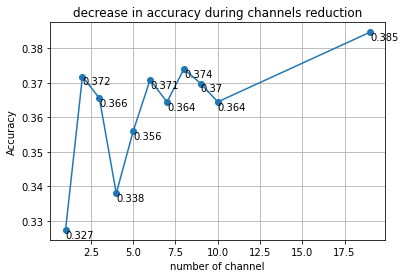

candidate of best selected channel:  [(9, 0.36972004479283316), (8, 0.3739753639417693), (6, 0.3708174692049272), (3, 0.36552071668533037), (2, 0.37178051511758115)]
maximum accuracy is 0.37 with 2 channel(s)


SubjectB-160311-epo.fif
Most used channel in all trial: 
 [('F7', 5), ('F8', 2), ('O1', 2), ('Fp1', 1), ('Fp2', 1), ('Cz', 1), ('T6', 1), ('T3', 1), ('F3', 1)]
Relevan channels in each class: 
 {'thumb': [(0.22384790430143076, 'Fp1'), (0.21694567850771296, 'Fp2'), (0.12021909662840256, 'F7')], 'index': [(0.20014493171298847, 'F8'), (0.18846292639520454, 'F7'), (0.1698391376542983, 'O1')], 'middle': [(0.1758604716247924, 'Cz'), (0.16433701942311046, 'F7'), (0.12406319922512762, 'T6')], 'ring': [(0.3168390610552601, 'F7'), (0.04886746983092647, 'T3'), (0.039732818184854836, 'F3')], 'pinky': [(0.30192332929002164, 'O1'), (0.21075835503410412, 'F8'), (0.17297981541567758, 'F7')]}
dropped channel  Fp1
dropped channel  Fp2
dropped channel  F3
dropped channel  Cz
dropped channel  T3
dr

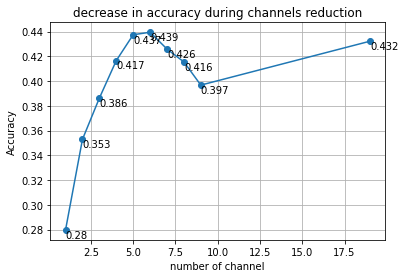

candidate of best selected channel:  [(8, 0.415515350877193), (7, 0.4259100877192982), (6, 0.43949561403508774), (5, 0.43747807017543855), (4, 0.41658991228070175)]
maximum accuracy is 0.42 with 4 channel(s)


SubjectB-160309-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 2), ('O2', 2), ('Fp1', 2), ('Fp2', 2), ('Cz', 2), ('Pz', 1), ('O1', 1)]
Relevan channels in each class: 
 {'thumb': [(0.2725809870691246, 'F8'), (0.2722203437757171, 'F7'), (0.19079428884931735, 'O2')], 'index': [(0.1377932510698313, 'Fp1'), (0.11554289408911407, 'F7'), (0.1072932873475137, 'Fp2')], 'middle': [(0.30608568493227656, 'Cz'), (0.20064506489810519, 'Fp1'), (0.19863493118676567, 'Pz')], 'ring': [(0.3933788997266914, 'Cz'), (0.2542029839253522, 'F8'), (0.24511275429516102, 'Fp2')], 'pinky': [(0.26779157072564486, 'O1'), (0.25123224169307945, 'F8'), (0.22223989880976647, 'O2')]}
dropped channel  O1
dropped channel  Pz
dropped channel  Fp2
dropped channel  Fp1
dropped channel  O2
dropped channel 

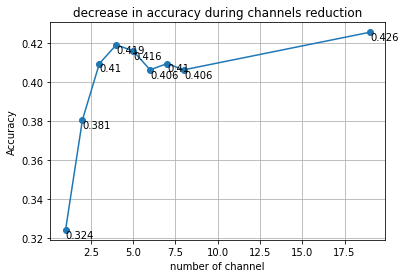

candidate of best selected channel:  [(8, 0.4064058567833448), (7, 0.40957446808510634), (6, 0.4064058567833448), (5, 0.416106154198124), (4, 0.4192518874399451), (3, 0.4095859071150767)]
maximum accuracy is 0.41 with 3 channel(s)


SubjectC-160429-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 3), ('Pz', 2), ('T4', 2), ('Fz', 2), ('Fp1', 2), ('Cz', 1)]
Relevan channels in each class: 
 {'thumb': [(0.30511129223543454, 'F8'), (0.14868812796495184, 'Pz'), (0.13917244358806202, 'T4')], 'index': [(0.1679955582591084, 'Fz'), (0.15884800129550614, 'Fp1'), (0.1220766630792991, 'F7')], 'middle': [(0.343027179784935, 'F8'), (0.252813714091194, 'F7'), (0.13524629179780417, 'T4')], 'ring': [(0.210731696578426, 'Cz'), (0.20827119796538648, 'Fz'), (0.18046767753445483, 'Pz')], 'pinky': [(0.2973318146264748, 'F7'), (0.2762990344213436, 'Fp1'), (0.19938476119742105, 'F8')]}
dropped channel  Cz
dropped channel  T4
dropped channel  Fz
dropped channel  Pz
dropped channel  Fp1
dropped chan

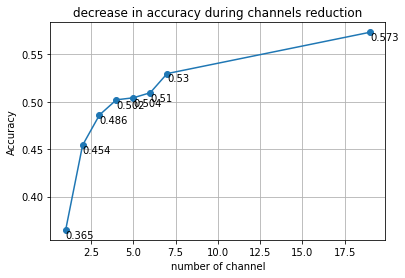

candidate of best selected channel:  []
maximum accuracy is 0.53 with 7 channel(s)


SubjectE-160321-epo.fif
Most used channel in all trial: 
 [('Fp1', 3), ('F7', 3), ('Fp2', 2), ('T4', 2), ('P3', 1), ('F8', 1), ('F4', 1), ('T5', 1), ('Fz', 1)]
Relevan channels in each class: 
 {'thumb': [(0.21445619021133944, 'P3'), (0.20748913166090194, 'F8'), (0.20505870128932044, 'F4')], 'index': [(0.2864784149945331, 'Fp1'), (0.26874591013330484, 'F7'), (0.26716982240760256, 'Fp2')], 'middle': [(0.19992723712515914, 'Fp2'), (0.15788518448620306, 'Fp1'), (0.1430110491147573, 'F7')], 'ring': [(0.040010422918934294, 'T5'), (0.0373883645412483, 'T4'), (0.031566798782126926, 'Fz')], 'pinky': [(0.20579314701234303, 'F7'), (0.19120030128648355, 'T4'), (0.18928569424842637, 'Fp1')]}
dropped channel  F4
dropped channel  Fz
dropped channel  P3
dropped channel  F8
dropped channel  T5
dropped channel  Fp2
dropped channel  T4
dropped channel  Fp1


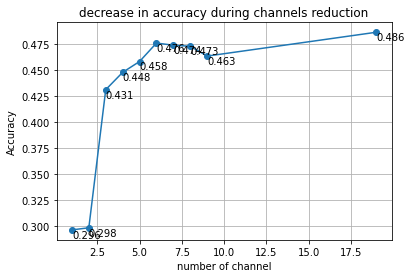

candidate of best selected channel:  [(8, 0.47268640350877195), (7, 0.4737280701754386), (6, 0.4757894736842106)]
maximum accuracy is 0.48 with 6 channel(s)


SubjectE-160429-epo.fif
Most used channel in all trial: 
 [('C3', 2), ('T4', 2), ('O1', 2), ('F7', 1), ('T3', 1), ('O2', 1), ('F4', 1), ('Fz', 1), ('Fp2', 1), ('Pz', 1), ('T6', 1), ('P4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.03395836797928386, 'C3'), (0.017720054280187122, 'T4'), (0.01722480725454694, 'F7')], 'index': [(0.1737293621319555, 'T3'), (0.11385209220579423, 'O1'), (0.10175521985718423, 'O2')], 'middle': [(0.037828434818890644, 'C3'), (0.02604573638508241, 'O1'), (0.019511263469250688, 'F4')], 'ring': [(0.08723818801670645, 'Fz'), (0.061004148307448866, 'T4'), (0.05566407797227199, 'Fp2')], 'pinky': [(0.2005034326074659, 'Pz'), (0.09667576772455208, 'T6'), (0.08715459779948476, 'P4')]}
dropped channel  Fp2
dropped channel  Fz
dropped channel  P4
dropped channel  O2
dropped channel  F7
dropped channel  Pz


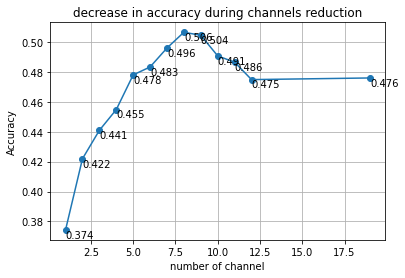

candidate of best selected channel:  [(12, 0.4748376259798432), (11, 0.48646136618141095), (10, 0.49067189249720045), (9, 0.5044456886898097), (8, 0.5064949608062711), (7, 0.49595744680851067), (6, 0.48329227323628227), (5, 0.47797312430011196)]
maximum accuracy is 0.48 with 5 channel(s)


SubjectE-160415-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('Fp2', 2), ('F3', 2), ('T4', 1), ('O1', 1), ('T5', 1), ('Pz', 1), ('C3', 1), ('P4', 1), ('Fp1', 1), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [(0.4943741892541992, 'F8'), (0.3708682901939174, 'Fp2'), (0.18088931331604297, 'T4')], 'index': [(0.06702454986200698, 'O1'), (0.06445387198735897, 'T5'), (0.04588038819903751, 'Pz')], 'middle': [(0.13992754576165833, 'Fp2'), (0.0756611415002515, 'C3'), (0.07106236826894038, 'F8')], 'ring': [(0.15943835979481627, 'P4'), (0.1321040615429141, 'F8'), (0.12426572650070068, 'F3')], 'pinky': [(0.269047474001225, 'Fp1'), (0.2614964071511634, 'F7'), (0.2579757789444037, 'F3')]}
dropped

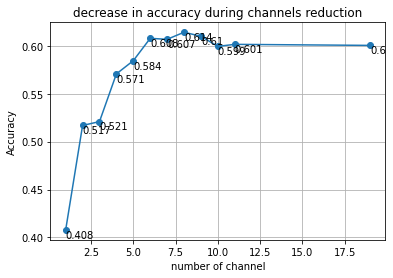

candidate of best selected channel:  [(11, 0.6014557670772677), (10, 0.5993393057110863), (9, 0.6098768197088467), (8, 0.6140873460246361), (7, 0.6067077267637178), (6, 0.6077379619260918), (5, 0.5844232922732362)]
maximum accuracy is 0.58 with 5 channel(s)


SubjectI-160723-epo.fif
Most used channel in all trial: 
 [('O1', 3), ('Fp2', 3), ('F7', 2), ('F4', 2), ('O2', 1), ('T5', 1), ('T6', 1), ('F8', 1), ('T3', 1)]
Relevan channels in each class: 
 {'thumb': [(0.14256515353446708, 'F7'), (0.13170898912472173, 'O2'), (0.12337398862781875, 'O1')], 'index': [(0.1562873094095879, 'Fp2'), (0.1542715194613549, 'T5'), (0.10207081658218066, 'O1')], 'middle': [(0.2414106238741871, 'T6'), (0.09964133445038845, 'Fp2'), (0.08358772467797292, 'F4')], 'ring': [(0.20766397349761773, 'F8'), (0.19436396828458555, 'F4'), (0.1549421627206366, 'Fp2')], 'pinky': [(0.3944487729261746, 'F7'), (0.19316636048465435, 'T3'), (0.19141943714449575, 'O1')]}
dropped channel  O2
dropped channel  T5
dropped channel  T

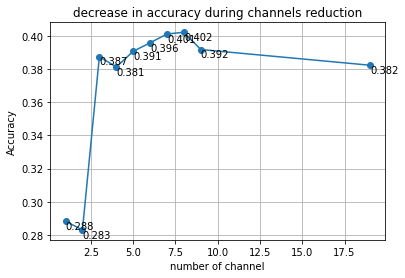

candidate of best selected channel:  [(9, 0.3917105263157895), (8, 0.4021271929824562), (7, 0.40106359649122814), (6, 0.39577850877192977), (5, 0.390625), (4, 0.38121710526315794), (3, 0.3874232456140351)]
maximum accuracy is 0.39 with 3 channel(s)


SubjectG-160428-epo.fif
Most used channel in all trial: 
 [('F7', 4), ('F8', 2), ('Fp1', 2), ('Fp2', 2), ('Pz', 1), ('O2', 1), ('O1', 1), ('T5', 1), ('C4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.21432194914012148, 'F8'), (0.14084413690076764, 'F7'), (0.06752731194989751, 'Fp1')], 'index': [(0.11823417422904722, 'Fp2'), (0.11708111526643472, 'F7'), (0.1040300961405256, 'Pz')], 'middle': [(0.1517978374266931, 'O2'), (0.14431852467793407, 'O1'), (0.032174412145610995, 'T5')], 'ring': [(0.2711699234603827, 'Fp1'), (0.21254894700464222, 'Fp2'), (0.08407466528858734, 'F7')], 'pinky': [(0.19757563041776027, 'F7'), (0.18590020450362935, 'F8'), (0.13423630066732156, 'C4')]}
dropped channel  O1
dropped channel  C4
dropped channel  Pz
dr

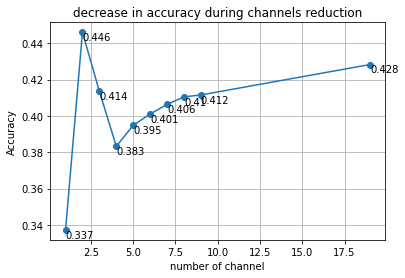

candidate of best selected channel:  [(9, 0.4115460526315789), (8, 0.41049342105263154), (3, 0.4135855263157895), (2, 0.44607456140350876)]
maximum accuracy is 0.45 with 2 channel(s)


mean of selected channel number : 4
relevan channel in all subject (modus) : 
 [('F8', 38), ('F7', 38), ('Fp1', 30), ('Fp2', 30), ('O1', 27), ('O2', 17), ('Cz', 15), ('Pz', 14), ('T6', 10), ('T5', 10), ('T4', 9), ('Fz', 8), ('F4', 8), ('F3', 8), ('C3', 6), ('T3', 5), ('P3', 4), ('C4', 4), ('P4', 4)]
mean of all subject accuracy:  0.432


In [ ]:
accuracy = mainProgram(channel_selection='multiclassCSP',n_chan_perclass=3,max_acc_decrease =0.02,
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

###STFT MRCP, SVM rbf

SubjectB-151110-epo.fif
Most used channel in all trial: 
 [('Fp1', 3), ('T6', 2), ('Fp2', 2), ('Cz', 2), ('P3', 1), ('C4', 1), ('C3', 1), ('O1', 1), ('T4', 1), ('F8', 1)]
Relevan channels in each class: 
 {'thumb': [(0.21747331645576767, 'T6'), (0.12472630834483556, 'P3'), (0.08003905096586807, 'Fp1')], 'index': [(0.278052196358776, 'Fp1'), (0.2060599825123729, 'Fp2'), (0.11269909941427801, 'C4')], 'middle': [(0.23934406255216448, 'T6'), (0.08760961460425165, 'Fp1'), (0.08073663471817925, 'C3')], 'ring': [(0.24628561911147456, 'Cz'), (0.14497191052287514, 'O1'), (0.1435307192382888, 'T4')], 'pinky': [(0.18777286506954677, 'F8'), (0.167418632428763, 'Cz'), (0.1234693161034423, 'Fp2')]}
dropped channel  T4
dropped channel  F8
dropped channel  C4
dropped channel  C3
dropped channel  O1
dropped channel  P3
dropped channel  Fp2
dropped channel  Cz
dropped channel  T6


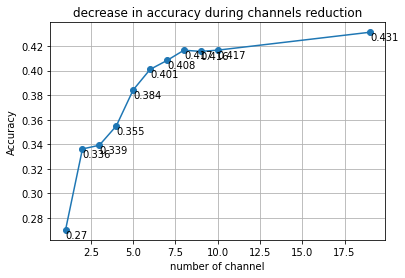

candidate of best selected channel:  [(10, 0.4165679824561404), (9, 0.4155701754385965), (8, 0.41651315789473686)]
maximum accuracy is 0.42 with 8 channel(s)


SubjectB-160316-epo.fif
Most used channel in all trial: 
 [('Cz', 4), ('O1', 4), ('T6', 2), ('F8', 1), ('O2', 1), ('T5', 1), ('Fp1', 1), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [(0.356501601698183, 'Cz'), (0.26534835592052947, 'T6'), (0.2548188396670097, 'O1')], 'index': [(0.28928263278204025, 'Cz'), (0.2439110454893447, 'O1'), (0.22754041124320454, 'F8')], 'middle': [(0.26789419752073196, 'T6'), (0.2561494406350111, 'Cz'), (0.19867974670847371, 'O2')], 'ring': [(0.3653387597532422, 'Cz'), (0.25588019123925465, 'O1'), (0.23836969309669997, 'T5')], 'pinky': [(0.28965890465236227, 'O1'), (0.2874888959067925, 'Fp1'), (0.22362412120904235, 'F7')]}
dropped channel  F7
dropped channel  O2
dropped channel  Fp1
dropped channel  T5
dropped channel  F8
dropped channel  T6
dropped channel  O1


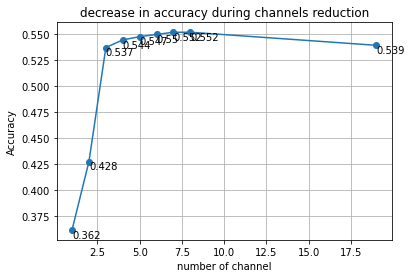

candidate of best selected channel:  [(8, 0.5516666666666665), (7, 0.5516557017543859), (6, 0.5495614035087719), (5, 0.5474342105263158), (4, 0.5443201754385965), (3, 0.5369956140350878)]
maximum accuracy is 0.54 with 3 channel(s)


SubjectC-151204-epo.fif
Most used channel in all trial: 
 [('Fp1', 3), ('Fp2', 2), ('O2', 2), ('Cz', 2), ('Fz', 2), ('F8', 1), ('F4', 1), ('C3', 1), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [(0.32349090204462927, 'Fp1'), (0.13816654232779133, 'F8'), (0.12579640500169847, 'F4')], 'index': [(0.22042464499938402, 'Fp2'), (0.18317954211401732, 'C3'), (0.15562722408577767, 'O2')], 'middle': [(0.5533399887807173, 'Fp2'), (0.4930433736440242, 'Fp1'), (0.3199978308832963, 'T5')], 'ring': [(0.22532570851866984, 'Cz'), (0.18212905759459286, 'Fz'), (0.1658527260689316, 'O2')], 'pinky': [(0.3799234227392033, 'Fp1'), (0.19059143944415388, 'Fz'), (0.18681536851388686, 'Cz')]}
dropped channel  F8
dropped channel  C3
dropped channel  F4
dropped channel  T5
dr

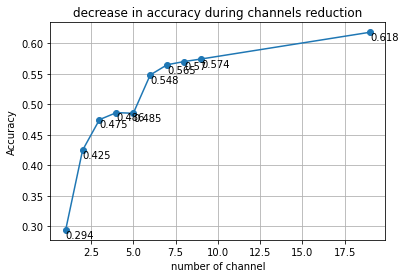

candidate of best selected channel:  []
maximum accuracy is 0.57 with 9 channel(s)


SubjectA-160405-epo.fif
Most used channel in all trial: 
 [('F8', 4), ('Fp1', 3), ('F7', 3), ('Fp2', 1), ('O2', 1), ('T5', 1), ('O1', 1), ('F3', 1)]
Relevan channels in each class: 
 {'thumb': [(0.4987734193739611, 'F8'), (0.4286773362814273, 'Fp2'), (0.22616676106389094, 'Fp1')], 'index': [(0.38754371148845174, 'F7'), (0.32334993271432966, 'Fp1'), (0.2154579569197585, 'F8')], 'middle': [(0.2710235819852041, 'F8'), (0.20842975187146434, 'O2'), (0.19572007741711014, 'T5')], 'ring': [(0.2629555142312519, 'F7'), (0.2057104229609033, 'F8'), (0.17708877764478304, 'O1')], 'pinky': [(0.46689764480915885, 'F7'), (0.4209174295395806, 'Fp1'), (0.21625514643969038, 'F3')]}
dropped channel  Fp2
dropped channel  F3
dropped channel  O1
dropped channel  O2
dropped channel  T5
dropped channel  Fp1
dropped channel  F7


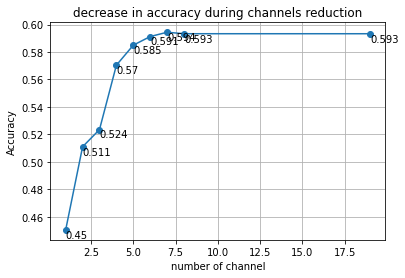

candidate of best selected channel:  [(8, 0.5933114035087719), (7, 0.5943859649122807), (6, 0.5912609649122806), (5, 0.5849780701754387)]
maximum accuracy is 0.58 with 5 channel(s)


SubjectF-151027-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('Cz', 2), ('Pz', 2), ('C3', 1), ('O2', 1), ('F4', 1), ('C4', 1), ('Fz', 1), ('O1', 1), ('P4', 1), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [(0.28107372635323913, 'Cz'), (0.2785671392813082, 'Pz'), (0.26421766152100123, 'F8')], 'index': [(0.1501583992639608, 'C3'), (0.1468505199821535, 'Pz'), (0.10725620864048337, 'O2')], 'middle': [(0.2917031113160073, 'F4'), (0.1709239026280069, 'C4'), (0.16865073211926138, 'F8')], 'ring': [(0.14889360511657151, 'Fz'), (0.12476828929148345, 'O1'), (0.10147648720903753, 'F8')], 'pinky': [(0.21629378979713604, 'P4'), (0.19402747967855344, 'Cz'), (0.18555584416496662, 'T5')]}
dropped channel  C4
dropped channel  C3
dropped channel  O2
dropped channel  Fz
dropped channel  O1
dropped channel  

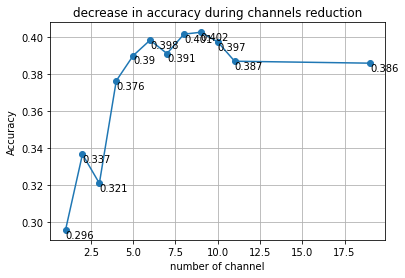

candidate of best selected channel:  [(11, 0.3868092105263158), (10, 0.3972258771929825), (9, 0.40244517543859654), (8, 0.4014035087719298), (7, 0.39094298245614034), (6, 0.39819078947368425), (5, 0.3898245614035088), (4, 0.37625)]
maximum accuracy is 0.38 with 4 channel(s)


SubjectF-160209-epo.fif
Most used channel in all trial: 
 [('Fp2', 2), ('O1', 2), ('F3', 2), ('Fp1', 1), ('O2', 1), ('T6', 1), ('T5', 1), ('Pz', 1), ('C4', 1), ('P4', 1), ('F8', 1), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [(0.23089476260879438, 'Fp1'), (0.2104546336819581, 'Fp2'), (0.14588642454983786, 'O1')], 'index': [(0.1656010894698798, 'O2'), (0.09851249430633616, 'T6'), (0.07950932792082774, 'T5')], 'middle': [(0.12151387955838083, 'Pz'), (0.09904971765742604, 'Fp2'), (0.054647603112557466, 'C4')], 'ring': [(0.0673208879964183, 'P4'), (0.024629359432332354, 'F3'), (0.022611732237013984, 'F8')], 'pinky': [(0.223569684886791, 'F7'), (0.12738216231610622, 'F3'), (0.11596145130696214, 'O1')]}
drop

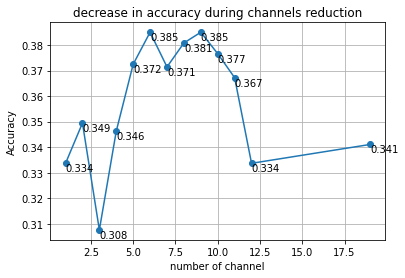

candidate of best selected channel:  [(12, 0.3336732456140351), (11, 0.3672039473684211), (10, 0.3766008771929824), (9, 0.38499999999999995), (8, 0.3808004385964912), (7, 0.37141447368421054), (6, 0.38499999999999995), (5, 0.3724671052631579), (4, 0.3462828947368421), (2, 0.3494298245614035), (1, 0.3336622807017544)]
maximum accuracy is 0.33 with 1 channel(s)


SubjectA-160408-epo.fif
Most used channel in all trial: 
 [('O1', 3), ('Fp1', 3), ('O2', 2), ('Fp2', 2), ('F8', 2), ('F7', 1), ('T3', 1), ('T4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.31242862435310054, 'O1'), (0.08650693685928179, 'O2'), (0.056176175521654645, 'Fp2')], 'index': [(0.2553927491555274, 'F7'), (0.167638182913324, 'O2'), (0.16523702241505417, 'Fp1')], 'middle': [(0.2671191801347943, 'O1'), (0.105673565070283, 'F8'), (0.08447593608615181, 'T3')], 'ring': [(0.2541048304746475, 'Fp1'), (0.10294903539644013, 'F8'), (0.06626436412996084, 'Fp2')], 'pinky': [(0.19626358674648542, 'O1'), (0.1287037543849978, 'F

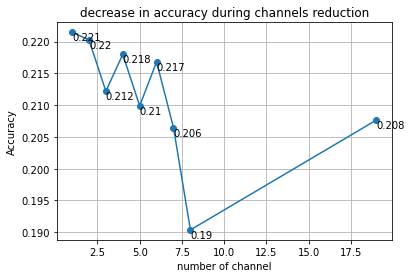

candidate of best selected channel:  [(8, 0.19036353916065224), (7, 0.20645549318364073), (6, 0.21681368618016572), (5, 0.2098904036353916), (4, 0.21798984228815826), (3, 0.21220261962042236), (2, 0.2202753274525528), (1, 0.22147821438118148)]
maximum accuracy is 0.22 with 1 channel(s)


SubjectI-160719-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 3), ('Fp2', 2), ('O1', 2), ('T3', 1), ('Pz', 1), ('F3', 1), ('O2', 1), ('Fp1', 1)]
Relevan channels in each class: 
 {'thumb': [(0.40973545891455604, 'F8'), (0.28764461304191435, 'F7'), (0.20573403191012613, 'Fp2')], 'index': [(0.4634279831099534, 'F7'), (0.2515638190874797, 'F8'), (0.17281532293818833, 'T3')], 'middle': [(0.14368433423207294, 'O1'), (0.1251313735776284, 'Pz'), (0.10468224153384677, 'F3')], 'ring': [(0.1574806270199648, 'O2'), (0.11203514020251315, 'O1'), (0.05984482753155873, 'Fp2')], 'pinky': [(0.46875740569636726, 'F7'), (0.2708662041557888, 'F8'), (0.22061579510195486, 'Fp1')]}
dropped channel  Fp1
dropped

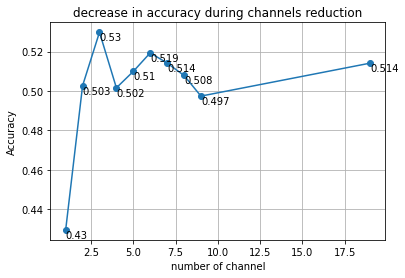

candidate of best selected channel:  [(9, 0.49741228070175436), (8, 0.5078728070175439), (7, 0.5141557017543861), (6, 0.5193201754385964), (5, 0.5099232456140351), (4, 0.5016008771929825), (3, 0.5297697368421053), (2, 0.5026754385964912)]
maximum accuracy is 0.5 with 2 channel(s)


SubjectH-160804-epo.fif
Most used channel in all trial: 
 [('Pz', 2), ('F8', 2), ('Fp2', 2), ('F7', 2), ('F4', 1), ('P3', 1), ('O1', 1), ('O2', 1), ('T6', 1), ('Fp1', 1), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [(0.18904268548348288, 'Pz'), (0.14276768732860168, 'F8'), (0.09847988497465486, 'F4')], 'index': [(0.13937522452692502, 'P3'), (0.10970595536813421, 'O1'), (0.06279404623609679, 'O2')], 'middle': [(0.16889776049522054, 'T6'), (0.1424813640527696, 'Fp2'), (0.12634607871496856, 'Fp1')], 'ring': [(0.18397850292404233, 'T5'), (0.15367391446505713, 'F7'), (0.10839586852126559, 'Pz')], 'pinky': [(0.288242668898849, 'F8'), (0.2813519085959971, 'F7'), (0.22311983726506146, 'Fp2')]}
dropped cha

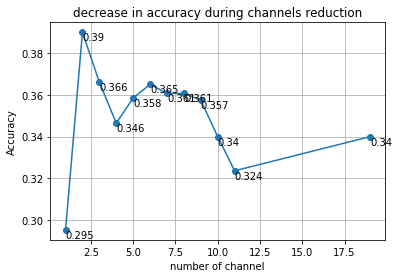

candidate of best selected channel:  [(11, 0.323632538569425), (10, 0.33992519869097715), (9, 0.35731650303880313), (8, 0.3606007480130903), (7, 0.3606007480130903), (6, 0.3649368863955119), (5, 0.3584151472650771), (4, 0.3463884992987377), (3, 0.3659303412809724), (2, 0.38983169705469856)]
maximum accuracy is 0.39 with 2 channel(s)


SubjectF-160210-epo.fif
Most used channel in all trial: 
 [('F7', 4), ('Pz', 2), ('Fp2', 2), ('O1', 2), ('F8', 2), ('Fp1', 1), ('O2', 1), ('F4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.23403792865153802, 'Pz'), (0.18768532975438013, 'Fp2'), (0.16427307026864324, 'F7')], 'index': [(0.19036218911006095, 'F7'), (0.1666917591981244, 'O1'), (0.14914219545032079, 'F8')], 'middle': [(0.19627079583204038, 'F7'), (0.1087371153061516, 'Fp1'), (0.10545621891727608, 'O2')], 'ring': [(0.20722770115711445, 'F4'), (0.12452872452301605, 'Fp2'), (0.10340625444861853, 'F8')], 'pinky': [(0.19529347020909826, 'O1'), (0.1516144891569181, 'F7'), (0.1269599555940965

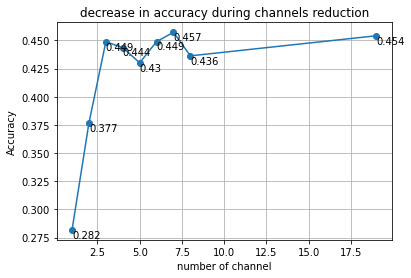

candidate of best selected channel:  [(8, 0.43633771929824566), (7, 0.4573026315789474), (6, 0.44896929824561405), (4, 0.44367324561403504), (3, 0.44889254385964905)]
maximum accuracy is 0.45 with 3 channel(s)


SubjectG-160413-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 2), ('Fp2', 2), ('Fp1', 2), ('Cz', 1), ('O2', 1), ('T6', 1), ('P3', 1), ('F3', 1), ('Fz', 1)]
Relevan channels in each class: 
 {'thumb': [(0.12078032935832425, 'F8'), (0.12051623211117635, 'F7'), (0.08450668893466706, 'Cz')], 'index': [(0.19569554300247097, 'Fp2'), (0.07707917100618578, 'Fp1'), (0.03651806101669608, 'F8')], 'middle': [(0.17238037401854023, 'O2'), (0.06295091119466975, 'T6'), (0.050291217845544176, 'Fp1')], 'ring': [(0.12017801240820447, 'P3'), (0.015158501784764413, 'Fp2'), (0.01500262437823527, 'F3')], 'pinky': [(0.22593406362161877, 'Fz'), (0.04370170959910765, 'F7'), (0.03941408232690866, 'F8')]}
dropped channel  F3
dropped channel  Fz
dropped channel  Cz
dropped channel  P3
droppe

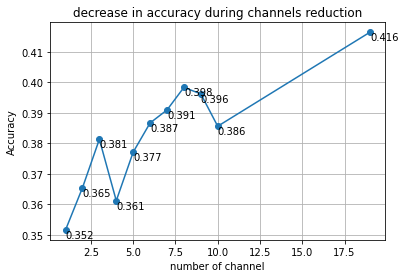

candidate of best selected channel:  [(8, 0.3983090705487122)]
maximum accuracy is 0.4 with 8 channel(s)


SubjectB-160311-epo.fif
Most used channel in all trial: 
 [('F7', 5), ('F8', 2), ('O1', 2), ('Fp1', 1), ('Fp2', 1), ('Cz', 1), ('T6', 1), ('T3', 1), ('F3', 1)]
Relevan channels in each class: 
 {'thumb': [(0.22384790430143076, 'Fp1'), (0.21694567850771296, 'Fp2'), (0.12021909662840256, 'F7')], 'index': [(0.20014493171298847, 'F8'), (0.18846292639520454, 'F7'), (0.1698391376542983, 'O1')], 'middle': [(0.1758604716247924, 'Cz'), (0.16433701942311046, 'F7'), (0.12406319922512762, 'T6')], 'ring': [(0.3168390610552601, 'F7'), (0.04886746983092647, 'T3'), (0.039732818184854836, 'F3')], 'pinky': [(0.30192332929002164, 'O1'), (0.21075835503410412, 'F8'), (0.17297981541567758, 'F7')]}
dropped channel  Fp2
dropped channel  F3
dropped channel  Fp1
dropped channel  Cz
dropped channel  T3
dropped channel  T6
dropped channel  O1
dropped channel  F8


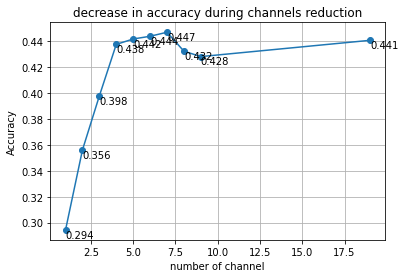

candidate of best selected channel:  [(9, 0.4280701754385965), (8, 0.43225877192982465), (7, 0.4468530701754386), (6, 0.44375), (5, 0.44164473684210526), (4, 0.4375)]
maximum accuracy is 0.44 with 4 channel(s)


SubjectB-160309-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 2), ('O2', 2), ('Fp1', 2), ('Fp2', 2), ('Cz', 2), ('Pz', 1), ('O1', 1)]
Relevan channels in each class: 
 {'thumb': [(0.2725809870691246, 'F8'), (0.2722203437757171, 'F7'), (0.19079428884931735, 'O2')], 'index': [(0.1377932510698313, 'Fp1'), (0.11554289408911407, 'F7'), (0.1072932873475137, 'Fp2')], 'middle': [(0.30608568493227656, 'Cz'), (0.20064506489810519, 'Fp1'), (0.19863493118676567, 'Pz')], 'ring': [(0.3933788997266914, 'Cz'), (0.2542029839253522, 'F8'), (0.24511275429516102, 'Fp2')], 'pinky': [(0.26779157072564486, 'O1'), (0.25123224169307945, 'F8'), (0.22223989880976647, 'O2')]}
dropped channel  Pz
dropped channel  O1
dropped channel  Fp2
dropped channel  O2
dropped channel  Fp1
dropped channe

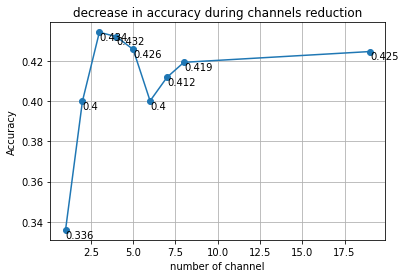

candidate of best selected channel:  [(8, 0.41927476549988557), (7, 0.41181651795927704), (5, 0.42569206131320064), (4, 0.4320407229466941), (3, 0.4342255776710135)]
maximum accuracy is 0.43 with 3 channel(s)


SubjectC-160429-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('F7', 3), ('Pz', 2), ('T4', 2), ('Fz', 2), ('Fp1', 2), ('Cz', 1)]
Relevan channels in each class: 
 {'thumb': [(0.30511129223543454, 'F8'), (0.14868812796495184, 'Pz'), (0.13917244358806202, 'T4')], 'index': [(0.1679955582591084, 'Fz'), (0.15884800129550614, 'Fp1'), (0.1220766630792991, 'F7')], 'middle': [(0.343027179784935, 'F8'), (0.252813714091194, 'F7'), (0.13524629179780417, 'T4')], 'ring': [(0.210731696578426, 'Cz'), (0.20827119796538648, 'Fz'), (0.18046767753445483, 'Pz')], 'pinky': [(0.2973318146264748, 'F7'), (0.2762990344213436, 'Fp1'), (0.19938476119742105, 'F8')]}
dropped channel  Cz
dropped channel  Fp1
dropped channel  Fz
dropped channel  T4
dropped channel  Pz
dropped channel  F8


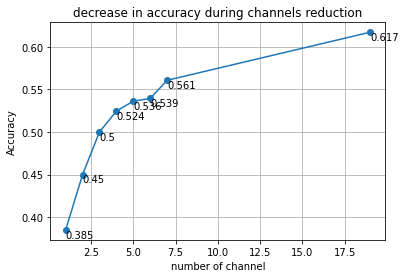

candidate of best selected channel:  []
maximum accuracy is 0.56 with 7 channel(s)


SubjectE-160321-epo.fif
Most used channel in all trial: 
 [('Fp1', 3), ('F7', 3), ('Fp2', 2), ('T4', 2), ('P3', 1), ('F8', 1), ('F4', 1), ('T5', 1), ('Fz', 1)]
Relevan channels in each class: 
 {'thumb': [(0.21445619021133944, 'P3'), (0.20748913166090194, 'F8'), (0.20505870128932044, 'F4')], 'index': [(0.2864784149945331, 'Fp1'), (0.26874591013330484, 'F7'), (0.26716982240760256, 'Fp2')], 'middle': [(0.19992723712515914, 'Fp2'), (0.15788518448620306, 'Fp1'), (0.1430110491147573, 'F7')], 'ring': [(0.040010422918934294, 'T5'), (0.0373883645412483, 'T4'), (0.031566798782126926, 'Fz')], 'pinky': [(0.20579314701234303, 'F7'), (0.19120030128648355, 'T4'), (0.18928569424842637, 'Fp1')]}
dropped channel  F8
dropped channel  Fz
dropped channel  P3
dropped channel  F4
dropped channel  T5
dropped channel  Fp2
dropped channel  T4
dropped channel  Fp1


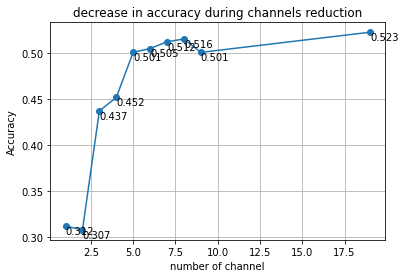

candidate of best selected channel:  [(8, 0.5156030701754386), (7, 0.5124561403508772), (6, 0.5051425438596491)]
maximum accuracy is 0.51 with 6 channel(s)


SubjectE-160429-epo.fif
Most used channel in all trial: 
 [('C3', 2), ('T4', 2), ('O1', 2), ('F7', 1), ('T3', 1), ('O2', 1), ('F4', 1), ('Fz', 1), ('Fp2', 1), ('Pz', 1), ('T6', 1), ('P4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.03395836797928386, 'C3'), (0.017720054280187122, 'T4'), (0.01722480725454694, 'F7')], 'index': [(0.1737293621319555, 'T3'), (0.11385209220579423, 'O1'), (0.10175521985718423, 'O2')], 'middle': [(0.037828434818890644, 'C3'), (0.02604573638508241, 'O1'), (0.019511263469250688, 'F4')], 'ring': [(0.08723818801670645, 'Fz'), (0.061004148307448866, 'T4'), (0.05566407797227199, 'Fp2')], 'pinky': [(0.2005034326074659, 'Pz'), (0.09667576772455208, 'T6'), (0.08715459779948476, 'P4')]}
dropped channel  Fp2
dropped channel  F4
dropped channel  P4
dropped channel  Pz
dropped channel  O2
dropped channel  F7
d

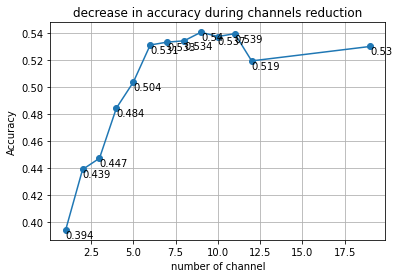

candidate of best selected channel:  [(12, 0.5192273236282194), (11, 0.5393169092945129), (10, 0.5372340425531915), (9, 0.5403919372900335), (8, 0.5340537513997761), (7, 0.5330907054871221), (6, 0.5309630459126541)]
maximum accuracy is 0.53 with 6 channel(s)


SubjectE-160415-epo.fif
Most used channel in all trial: 
 [('F8', 3), ('Fp2', 2), ('F3', 2), ('T4', 1), ('O1', 1), ('T5', 1), ('Pz', 1), ('C3', 1), ('P4', 1), ('Fp1', 1), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [(0.4943741892541992, 'F8'), (0.3708682901939174, 'Fp2'), (0.18088931331604297, 'T4')], 'index': [(0.06702454986200698, 'O1'), (0.06445387198735897, 'T5'), (0.04588038819903751, 'Pz')], 'middle': [(0.13992754576165833, 'Fp2'), (0.0756611415002515, 'C3'), (0.07106236826894038, 'F8')], 'ring': [(0.15943835979481627, 'P4'), (0.1321040615429141, 'F8'), (0.12426572650070068, 'F3')], 'pinky': [(0.269047474001225, 'Fp1'), (0.2614964071511634, 'F7'), (0.2579757789444037, 'F3')]}
dropped channel  C3
dropped channel  

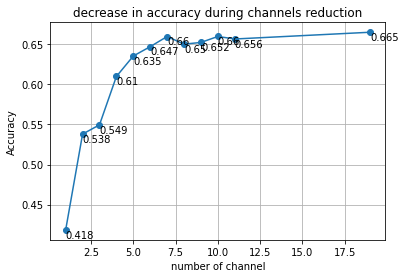

candidate of best selected channel:  [(11, 0.656494960806271), (10, 0.6596640537513998), (9, 0.6522172452407615), (8, 0.6500671892497201), (7, 0.6596080627099663), (6, 0.6469540873460247)]
maximum accuracy is 0.65 with 6 channel(s)


SubjectI-160723-epo.fif
Most used channel in all trial: 
 [('O1', 3), ('Fp2', 3), ('F7', 2), ('F4', 2), ('O2', 1), ('T5', 1), ('T6', 1), ('F8', 1), ('T3', 1)]
Relevan channels in each class: 
 {'thumb': [(0.14256515353446708, 'F7'), (0.13170898912472173, 'O2'), (0.12337398862781875, 'O1')], 'index': [(0.1562873094095879, 'Fp2'), (0.1542715194613549, 'T5'), (0.10207081658218066, 'O1')], 'middle': [(0.2414106238741871, 'T6'), (0.09964133445038845, 'Fp2'), (0.08358772467797292, 'F4')], 'ring': [(0.20766397349761773, 'F8'), (0.19436396828458555, 'F4'), (0.1549421627206366, 'Fp2')], 'pinky': [(0.3944487729261746, 'F7'), (0.19316636048465435, 'T3'), (0.19141943714449575, 'O1')]}
dropped channel  T6
dropped channel  T5
dropped channel  T3
dropped channel  O2
drop

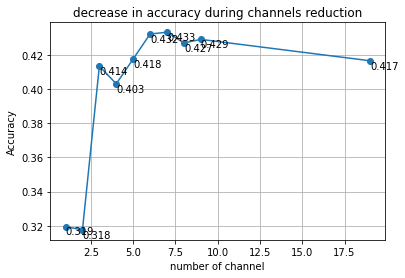

candidate of best selected channel:  [(9, 0.4292324561403508), (8, 0.42716008771929825), (7, 0.433421052631579), (6, 0.432390350877193), (5, 0.4177521929824562), (4, 0.4031688596491228), (3, 0.4135745614035088)]
maximum accuracy is 0.41 with 3 channel(s)


SubjectG-160428-epo.fif
Most used channel in all trial: 
 [('F7', 4), ('F8', 2), ('Fp1', 2), ('Fp2', 2), ('Pz', 1), ('O2', 1), ('O1', 1), ('T5', 1), ('C4', 1)]
Relevan channels in each class: 
 {'thumb': [(0.21432194914012148, 'F8'), (0.14084413690076764, 'F7'), (0.06752731194989751, 'Fp1')], 'index': [(0.11823417422904722, 'Fp2'), (0.11708111526643472, 'F7'), (0.1040300961405256, 'Pz')], 'middle': [(0.1517978374266931, 'O2'), (0.14431852467793407, 'O1'), (0.032174412145610995, 'T5')], 'ring': [(0.2711699234603827, 'Fp1'), (0.21254894700464222, 'Fp2'), (0.08407466528858734, 'F7')], 'pinky': [(0.19757563041776027, 'F7'), (0.18590020450362935, 'F8'), (0.13423630066732156, 'C4')]}
dropped channel  O2
dropped channel  Pz
dropped channel 

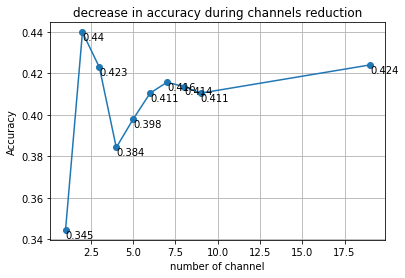

candidate of best selected channel:  [(9, 0.410515350877193), (8, 0.41366228070175437), (7, 0.41574561403508764), (6, 0.4105043859649123), (3, 0.4229824561403509), (2, 0.4398684210526316)]
maximum accuracy is 0.44 with 2 channel(s)


mean of selected channel number : 4
relevan channel in all subject (modus) : 
 [('F8', 38), ('F7', 38), ('Fp1', 30), ('Fp2', 30), ('O1', 27), ('O2', 17), ('Cz', 15), ('Pz', 14), ('T6', 10), ('T5', 10), ('T4', 9), ('Fz', 8), ('F4', 8), ('F3', 8), ('C3', 6), ('T3', 5), ('P3', 4), ('C4', 4), ('P4', 4)]
mean of all subject accuracy:  0.461


In [ ]:
accuracy = mainProgram(channel_selection='multiclassCSP',n_chan_perclass=3,max_acc_decrease =0.02,
                       features_extraction='STFT', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

##PCA channels selection

###FTA MRCP 'allAmplitude', SVM rbf

SubjectB-151110-epo.fif
Most used channel in all trial: 
 [('C4', 429), ('C3', 279), ('T4', 60), ('Cz', 48), ('Fp1', 26), ('T3', 22), ('P4', 21), ('Fz', 12), ('F4', 12), ('F7', 10), ('F3', 9), ('F8', 8), ('Fp2', 6), ('Pz', 6), ('P3', 4), ('T6', 4), ('T5', 2)]
Relevan channels in each class: 
 {'thumb': [('C4', 108), ('C3', 57), ('Cz', 14)], 'index': [('C4', 83), ('C3', 61), ('T4', 11)], 'middle': [('C4', 82), ('C3', 57), ('T4', 10)], 'ring': [('C4', 78), ('C3', 46), ('T4', 16)], 'pinky': [('C4', 78), ('C3', 58), ('T4', 13)]}
dropped channel  T5
dropped channel  P3
dropped channel  T6
dropped channel  Fp2
dropped channel  Pz
dropped channel  F8
dropped channel  F3
dropped channel  F7
dropped channel  F4
dropped channel  Fz
dropped channel  P4
dropped channel  T3
dropped channel  Fp1
dropped channel  Cz
dropped channel  T4
dropped channel  C3


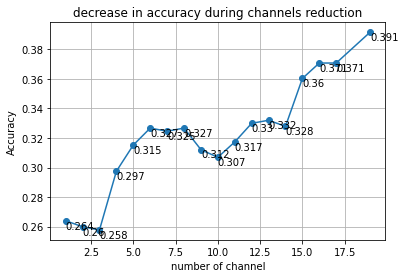

candidate of best selected channel:  []
maximum accuracy is 0.37 with 17 channel(s)


SubjectB-160316-epo.fif
Most used channel in all trial: 
 [('C3', 333), ('C4', 278), ('T3', 88), ('Fz', 80), ('Cz', 35), ('F7', 34), ('F3', 20), ('F8', 19), ('P3', 19), ('Fp1', 10), ('T4', 10), ('Fp2', 8), ('Pz', 7), ('T6', 7), ('P4', 5), ('F4', 4), ('T5', 1), ('O1', 1)]
Relevan channels in each class: 
 {'thumb': [('C4', 68), ('C3', 66), ('Fz', 22)], 'index': [('C3', 75), ('C4', 51), ('Fz', 18)], 'middle': [('C4', 62), ('C3', 60), ('T3', 21)], 'ring': [('C3', 63), ('C4', 53), ('T3', 26)], 'pinky': [('C3', 69), ('C4', 44), ('Fz', 15)]}
dropped channel  T5
dropped channel  O1
dropped channel  F4
dropped channel  P4
dropped channel  Pz
dropped channel  T6
dropped channel  Fp2
dropped channel  Fp1
dropped channel  T4
dropped channel  F8
dropped channel  P3
dropped channel  F3
dropped channel  F7
dropped channel  Cz
dropped channel  Fz
dropped channel  T3
dropped channel  C4


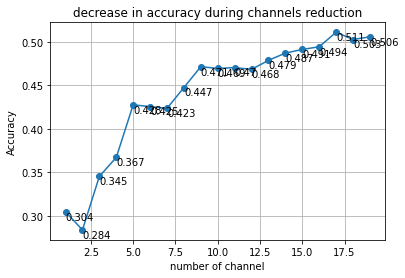

candidate of best selected channel:  [(18, 0.5025986842105262), (17, 0.5109649122807017), (16, 0.4942763157894737), (15, 0.4911622807017544), (14, 0.486984649122807)]
maximum accuracy is 0.49 with 14 channel(s)


SubjectC-151204-epo.fif
Most used channel in all trial: 
 [('C4', 503), ('C3', 240), ('T4', 60), ('Fp1', 53), ('Fp2', 16), ('F8', 16), ('Cz', 15), ('P4', 12), ('F7', 10), ('F3', 10), ('Pz', 6), ('T5', 6), ('Fz', 4), ('O1', 2), ('F4', 2), ('T3', 1), ('O2', 1), ('P3', 1)]
Relevan channels in each class: 
 {'thumb': [('C4', 76), ('C3', 45), ('Fp1', 15)], 'index': [('C4', 103), ('C3', 52), ('Fp1', 12)], 'middle': [('C4', 111), ('C3', 51), ('T4', 11)], 'ring': [('C4', 110), ('C3', 41), ('T4', 12)], 'pinky': [('C4', 103), ('C3', 51), ('T4', 16)]}
dropped channel  T3
dropped channel  O2
dropped channel  P3
dropped channel  F4
dropped channel  O1
dropped channel  Fz
dropped channel  Pz
dropped channel  T5
dropped channel  F3
dropped channel  F7
dropped channel  P4
dropped channel  Cz


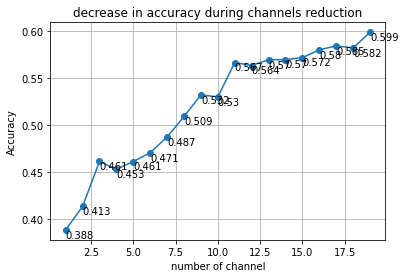

candidate of best selected channel:  [(18, 0.5824451754385964), (17, 0.5845833333333335), (16, 0.5803837719298245)]
maximum accuracy is 0.58 with 16 channel(s)


SubjectA-160405-epo.fif
Most used channel in all trial: 
 [('C3', 285), ('C4', 261), ('P3', 53), ('T4', 50), ('Cz', 36), ('T3', 36), ('Fz', 34), ('F8', 28), ('Pz', 26), ('F4', 23), ('F3', 23), ('F7', 22), ('O1', 22), ('T6', 19), ('O2', 13), ('Fp2', 11), ('Fp1', 9), ('P4', 6), ('T5', 2)]
Relevan channels in each class: 
 {'thumb': [('C3', 70), ('C4', 50), ('P3', 14)], 'index': [('C4', 52), ('C3', 46), ('P3', 10)], 'middle': [('C3', 63), ('C4', 58), ('T4', 11)], 'ring': [('C3', 55), ('C4', 48), ('Fz', 10)], 'pinky': [('C4', 53), ('C3', 51), ('T4', 14)]}
dropped channel  T5
dropped channel  P4
dropped channel  Fp1
dropped channel  Fp2
dropped channel  O2
dropped channel  T6
dropped channel  O1
dropped channel  F7
dropped channel  F4
dropped channel  F3
dropped channel  Pz
dropped channel  F8
dropped channel  Fz
dropped channel  C

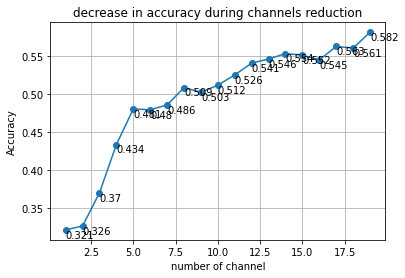

candidate of best selected channel:  [(17, 0.5631030701754385)]
maximum accuracy is 0.56 with 17 channel(s)


SubjectF-151027-epo.fif
Most used channel in all trial: 
 [('C3', 282), ('C4', 281), ('T6', 103), ('T4', 41), ('F7', 39), ('T3', 38), ('O1', 36), ('F3', 28), ('Cz', 19), ('F4', 17), ('P3', 17), ('Fp1', 14), ('P4', 14), ('F8', 10), ('Fp2', 8), ('O2', 4), ('Pz', 2), ('T5', 2), ('Fz', 2)]
Relevan channels in each class: 
 {'thumb': [('C4', 67), ('C3', 57), ('T6', 27)], 'index': [('C4', 61), ('C3', 41), ('T6', 20)], 'middle': [('C4', 62), ('C3', 44), ('T6', 22)], 'ring': [('C3', 76), ('C4', 40), ('O1', 16)], 'pinky': [('C3', 64), ('C4', 51), ('T6', 22)]}
dropped channel  Fz
dropped channel  Pz
dropped channel  T5
dropped channel  O2
dropped channel  Fp2
dropped channel  F8
dropped channel  Fp1
dropped channel  P4
dropped channel  F4
dropped channel  P3
dropped channel  Cz
dropped channel  F3
dropped channel  O1
dropped channel  T3
dropped channel  F7
dropped channel  T4
dropped cha

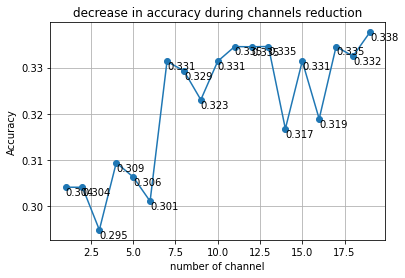

candidate of best selected channel:  [(18, 0.33247807017543857), (17, 0.3345504385964912), (16, 0.3188815789473684), (15, 0.33140350877192976), (13, 0.3345723684210526), (12, 0.3345175438596491), (11, 0.3345504385964912), (10, 0.3313706140350877), (9, 0.3230263157894736), (8, 0.3292982456140351), (7, 0.3313486842105263)]
maximum accuracy is 0.33 with 7 channel(s)


SubjectF-160209-epo.fif
Most used channel in all trial: 
 [('C4', 267), ('Fz', 245), ('P4', 223), ('F4', 54), ('T3', 46), ('C3', 32), ('F3', 21), ('Cz', 15), ('T5', 13), ('P3', 10), ('Fp2', 9), ('T4', 4), ('T6', 4), ('F7', 4), ('O1', 3), ('O2', 2), ('F8', 2), ('Pz', 2)]
Relevan channels in each class: 
 {'thumb': [('Fz', 62), ('C4', 56), ('P4', 42)], 'index': [('C4', 53), ('P4', 41), ('Fz', 37)], 'middle': [('C4', 62), ('Fz', 47), ('P4', 45)], 'ring': [('Fz', 48), ('P4', 47), ('C4', 46)], 'pinky': [('Fz', 51), ('C4', 50), ('P4', 48)]}
dropped channel  O2
dropped channel  Pz
dropped channel  F8
dropped channel  O1
dropped cha

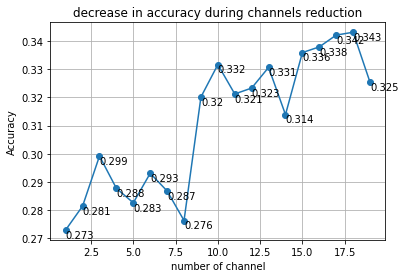

candidate of best selected channel:  [(18, 0.34315789473684205), (17, 0.3421491228070175), (16, 0.33796052631578943), (15, 0.33593201754385965), (14, 0.31390350877192985), (13, 0.3306688596491228), (12, 0.32333333333333336), (11, 0.32123903508771934), (10, 0.33166666666666667), (9, 0.32015350877192983)]
maximum accuracy is 0.32 with 9 channel(s)


SubjectA-160408-epo.fif
Most used channel in all trial: 
 [('C3', 290), ('C4', 281), ('T3', 57), ('Cz', 50), ('T4', 32), ('Fz', 30), ('P3', 25), ('F3', 15), ('P4', 14), ('T6', 14), ('F7', 12), ('Fp2', 11), ('F8', 9), ('O1', 7), ('Pz', 7), ('Fp1', 6), ('F4', 4), ('O2', 2), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [('C4', 68), ('C3', 66), ('Cz', 11)], 'index': [('C4', 53), ('C3', 43), ('T3', 17)], 'middle': [('C3', 68), ('C4', 49), ('T3', 14)], 'ring': [('C3', 58), ('C4', 52), ('Cz', 13)], 'pinky': [('C4', 59), ('C3', 55), ('T3', 10)]}
dropped channel  T5
dropped channel  O2
dropped channel  F4
dropped channel  Fp1
dropped channel

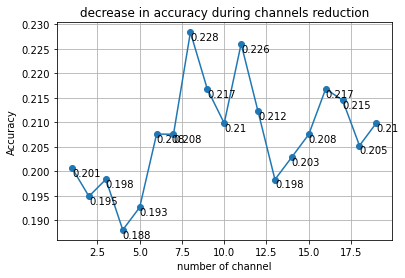

candidate of best selected channel:  [(18, 0.20525260625501204), (17, 0.2145148356054531), (16, 0.21681368618016572), (15, 0.2075514568297247), (14, 0.2029270248596632), (13, 0.198342689120556), (12, 0.21222935044105853), (11, 0.2259957230686982), (10, 0.2098235765838011), (9, 0.21677358994921145), (8, 0.22836140069500135), (7, 0.20757818765036085), (6, 0.20760491847099707), (5, 0.19267575514568297), (3, 0.19838278535151027), (2, 0.19492114407912325), (1, 0.20068163592622296)]
maximum accuracy is 0.2 with 1 channel(s)


SubjectI-160719-epo.fif
Most used channel in all trial: 
 [('C3', 288), ('C4', 256), ('F7', 133), ('F3', 44), ('F8', 39), ('P4', 32), ('Pz', 29), ('P3', 28), ('F4', 25), ('Fz', 24), ('Cz', 22), ('Fp2', 11), ('T4', 10), ('T3', 6), ('Fp1', 5), ('O1', 2), ('O2', 2), ('T6', 2), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 60), ('C4', 59), ('F7', 32)], 'index': [('C4', 50), ('C3', 44), ('F7', 31)], 'middle': [('C3', 57), ('C4', 49), ('F7', 27)], 'ring': [('

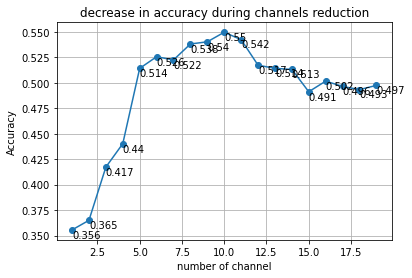

candidate of best selected channel:  [(18, 0.4932675438596492), (17, 0.4964254385964913), (16, 0.5016228070175439), (15, 0.4911951754385965), (14, 0.5131140350877192), (13, 0.5141447368421053), (12, 0.517280701754386), (11, 0.5423355263157895), (10, 0.5496162280701755), (9, 0.5402302631578948), (8, 0.5380811403508771), (7, 0.5224342105263158), (6, 0.5255811403508772), (5, 0.5141447368421053)]
maximum accuracy is 0.51 with 5 channel(s)


SubjectH-160804-epo.fif
Most used channel in all trial: 
 [('Fp1', 359), ('C4', 228), ('C3', 220), ('Cz', 30), ('Fp2', 13), ('F4', 12), ('P4', 9), ('Fz', 8), ('F7', 6), ('Pz', 6), ('O2', 5), ('P3', 5), ('O1', 5), ('F8', 5), ('T5', 4), ('T3', 3), ('F3', 1), ('T6', 1), ('T4', 1)]
Relevan channels in each class: 
 {'thumb': [('Fp1', 74), ('C4', 50), ('C3', 46)], 'index': [('Fp1', 79), ('C4', 44), ('C3', 31)], 'middle': [('Fp1', 73), ('C4', 48), ('C3', 46)], 'ring': [('Fp1', 74), ('C3', 54), ('C4', 35)], 'pinky': [('Fp1', 59), ('C4', 51), ('C3', 43)]}
dropp

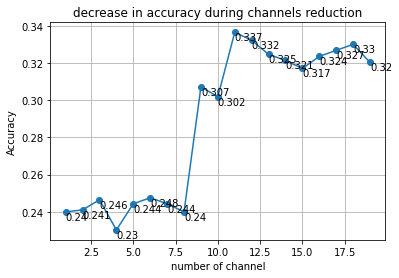

candidate of best selected channel:  [(18, 0.3301542776998597), (17, 0.32690509583917715), (16, 0.3236442262739598), (15, 0.31713417484805984), (14, 0.3214820009350164), (13, 0.32476624590930336), (12, 0.3322931276297335), (11, 0.33665264142122486), (10, 0.3019050958391772), (9, 0.3072697522206639)]
maximum accuracy is 0.31 with 9 channel(s)


SubjectF-160210-epo.fif
Most used channel in all trial: 
 [('C3', 302), ('C4', 175), ('P3', 145), ('T4', 112), ('T3', 42), ('F3', 42), ('Fp2', 32), ('Fz', 30), ('P4', 29), ('F8', 12), ('O1', 11), ('Fp1', 6), ('T6', 5), ('F4', 4), ('F7', 4), ('Cz', 3), ('Pz', 2), ('T5', 1), ('O2', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 67), ('C4', 40), ('T4', 28)], 'index': [('C3', 50), ('C4', 35), ('P3', 28)], 'middle': [('C3', 66), ('C4', 34), ('T4', 26)], 'ring': [('C3', 60), ('P3', 35), ('C4', 28)], 'pinky': [('C3', 59), ('P3', 39), ('C4', 38)]}
dropped channel  O2
dropped channel  T5
dropped channel  Pz
dropped channel  Cz
dropped channel  F7

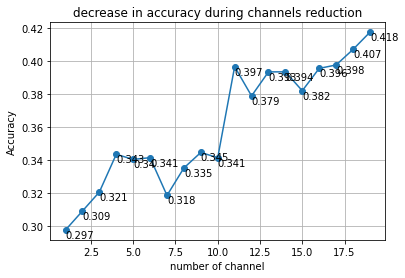

candidate of best selected channel:  [(18, 0.40711622807017545), (17, 0.39769736842105263)]
maximum accuracy is 0.4 with 17 channel(s)


SubjectG-160413-epo.fif
Most used channel in all trial: 
 [('C3', 334), ('C4', 237), ('Fp1', 68), ('P3', 66), ('P4', 56), ('Fz', 41), ('Cz', 38), ('Pz', 17), ('F7', 12), ('F8', 12), ('O2', 10), ('F3', 9), ('T3', 9), ('F4', 9), ('Fp2', 8), ('T4', 8), ('T5', 6), ('T6', 3), ('O1', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 73), ('C4', 44), ('P3', 18)], 'index': [('C3', 57), ('C4', 48), ('P3', 10)], 'middle': [('C3', 75), ('C4', 41), ('Fp1', 21)], 'ring': [('C3', 77), ('C4', 47), ('P4', 14)], 'pinky': [('C4', 57), ('C3', 52), ('P3', 17)]}
dropped channel  O1
dropped channel  T6
dropped channel  T5
dropped channel  Fp2
dropped channel  T4
dropped channel  F3
dropped channel  F4
dropped channel  T3
dropped channel  O2
dropped channel  F7
dropped channel  F8
dropped channel  Pz
dropped channel  Cz
dropped channel  Fz
dropped channel  P4
dropped 

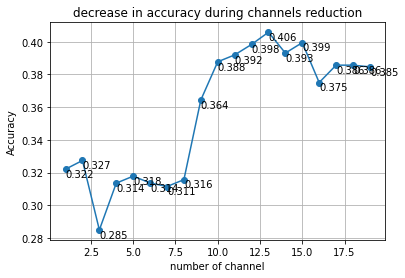

candidate of best selected channel:  [(18, 0.3856550951847705), (17, 0.3856550951847704), (16, 0.3750391937290034), (15, 0.399417693169093), (14, 0.393057110862262), (13, 0.4057782754759239), (12, 0.3983202687569989), (11, 0.3919148936170213), (10, 0.3877267637178051)]
maximum accuracy is 0.39 with 10 channel(s)


SubjectB-160311-epo.fif
Most used channel in all trial: 
 [('C3', 336), ('C4', 276), ('T4', 231), ('Cz', 22), ('F7', 21), ('F4', 13), ('P3', 11), ('P4', 10), ('F8', 10), ('Fp2', 8), ('T6', 4), ('Fz', 4), ('T3', 4), ('Fp1', 4), ('Pz', 3), ('F3', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 72), ('C4', 64), ('T4', 43)], 'index': [('C3', 63), ('C4', 51), ('T4', 37)], 'middle': [('C3', 68), ('C4', 58), ('T4', 55)], 'ring': [('C3', 64), ('C4', 52), ('T4', 51)], 'pinky': [('C3', 69), ('C4', 51), ('T4', 45)]}
dropped channel  F3
dropped channel  Pz
dropped channel  Fz
dropped channel  Fp1
dropped channel  T3
dropped channel  T6
dropped channel  Fp2
dropped channel  P4
dro

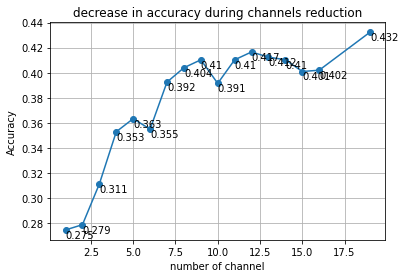

candidate of best selected channel:  [(13, 0.41237938596491225), (12, 0.41653508771929826)]
maximum accuracy is 0.42 with 12 channel(s)


SubjectB-160309-epo.fif
Most used channel in all trial: 
 [('C3', 465), ('C4', 168), ('P3', 58), ('Cz', 36), ('Fp1', 33), ('P4', 29), ('Fz', 23), ('F7', 17), ('F3', 17), ('F8', 17), ('Pz', 17), ('Fp2', 15), ('T4', 13), ('T3', 9), ('F4', 9), ('T6', 5), ('T5', 3), ('O2', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 104), ('C4', 33), ('P3', 15)], 'index': [('C3', 84), ('C4', 27), ('Fp1', 8)], 'middle': [('C3', 91), ('C4', 42), ('P3', 11)], 'ring': [('C3', 95), ('C4', 29), ('P3', 13)], 'pinky': [('C3', 91), ('C4', 37), ('Cz', 11)]}
dropped channel  O2
dropped channel  T5
dropped channel  T6
dropped channel  F4
dropped channel  T3
dropped channel  T4
dropped channel  Fp2
dropped channel  F3
dropped channel  F7
dropped channel  Pz
dropped channel  F8
dropped channel  Fz
dropped channel  P4
dropped channel  Fp1
dropped channel  Cz
dropped channel

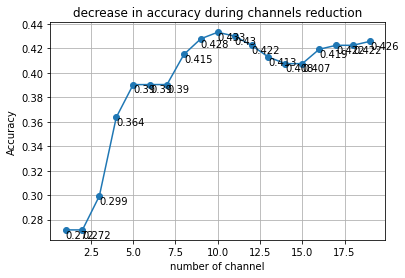

candidate of best selected channel:  [(18, 0.4224891329215283), (17, 0.42247769389155804), (16, 0.4192404484099749), (15, 0.4074925646305193), (14, 0.4075154426904598), (13, 0.41286890871654086), (12, 0.42248913292152823), (11, 0.42993594143216657), (10, 0.4331617478837795), (9, 0.427831159917639), (8, 0.4150194463509494)]
maximum accuracy is 0.42 with 8 channel(s)


SubjectC-160429-epo.fif
Most used channel in all trial: 
 [('C3', 404), ('C4', 398), ('Cz', 44), ('P4', 18), ('Fz', 14), ('T4', 11), ('F4', 8), ('F3', 7), ('T3', 7), ('Fp1', 6), ('Pz', 5), ('Fp2', 5), ('O1', 4), ('F8', 3), ('T5', 3), ('P3', 2), ('O2', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 85), ('C4', 84), ('Cz', 14)], 'index': [('C4', 74), ('C3', 70), ('Cz', 9)], 'middle': [('C3', 81), ('C4', 77), ('Cz', 12)], 'ring': [('C4', 86), ('C3', 79), ('Fz', 6)], 'pinky': [('C3', 89), ('C4', 77), ('Cz', 5)]}
dropped channel  O2
dropped channel  P3
dropped channel  T5
dropped channel  F8
dropped channel  O1
dropped

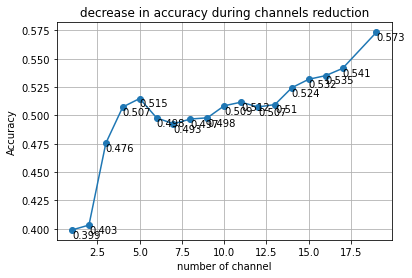

candidate of best selected channel:  []
maximum accuracy is 0.54 with 17 channel(s)


SubjectE-160321-epo.fif
Most used channel in all trial: 
 [('Cz', 193), ('P3', 174), ('C3', 119), ('C4', 109), ('T3', 83), ('T5', 56), ('O1', 33), ('T4', 32), ('Fz', 30), ('O2', 29), ('Fp2', 20), ('P4', 20), ('Pz', 19), ('Fp1', 12), ('F8', 11), ('F4', 8), ('F7', 7), ('T6', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 38), ('Cz', 37), ('P3', 35)], 'index': [('P3', 40), ('Cz', 38), ('C3', 22)], 'middle': [('Cz', 43), ('P3', 40), ('C4', 30)], 'ring': [('Cz', 41), ('P3', 28), ('C3', 19)], 'pinky': [('Cz', 34), ('P3', 31), ('C4', 24)]}
dropped channel  T6
dropped channel  F7
dropped channel  F4
dropped channel  F8
dropped channel  Fp1
dropped channel  Pz
dropped channel  Fp2
dropped channel  P4
dropped channel  O2
dropped channel  Fz
dropped channel  T4
dropped channel  O1
dropped channel  T5
dropped channel  T3
dropped channel  C4
dropped channel  C3
dropped channel  P3


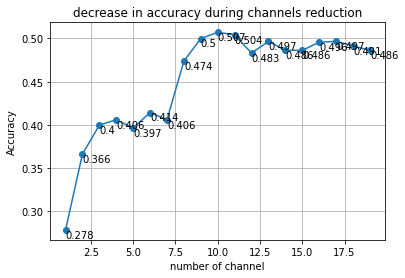

candidate of best selected channel:  [(18, 0.4914583333333333), (17, 0.4966666666666667), (16, 0.49565789473684213), (15, 0.48624999999999996), (14, 0.48624999999999996), (13, 0.4967214912280702), (12, 0.4831140350877193), (11, 0.5041337719298246), (10, 0.5072368421052632), (9, 0.49993421052631576), (8, 0.4738486842105264)]
maximum accuracy is 0.47 with 8 channel(s)


SubjectE-160429-epo.fif
Most used channel in all trial: 
 [('F4', 241), ('C4', 187), ('F3', 149), ('T4', 89), ('Cz', 55), ('Fz', 49), ('C3', 47), ('Fp1', 33), ('O2', 23), ('P3', 17), ('Fp2', 16), ('P4', 11), ('F7', 8), ('F8', 7), ('O1', 6), ('T6', 4), ('T3', 3), ('Pz', 1)]
Relevan channels in each class: 
 {'thumb': [('F4', 53), ('C4', 39), ('F3', 32)], 'index': [('F4', 58), ('C4', 23), ('F3', 23)], 'middle': [('F4', 42), ('F3', 38), ('C4', 31)], 'ring': [('F4', 48), ('C4', 47), ('F3', 26)], 'pinky': [('C4', 47), ('F4', 40), ('F3', 30)]}
dropped channel  Pz
dropped channel  T3
dropped channel  T6
dropped channel  O1
dropp

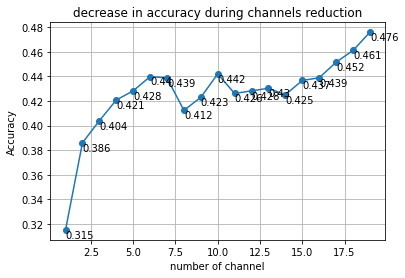

candidate of best selected channel:  [(18, 0.461097424412094)]
maximum accuracy is 0.46 with 18 channel(s)


SubjectE-160415-epo.fif
Most used channel in all trial: 
 [('Fz', 239), ('Cz', 152), ('C4', 121), ('C3', 107), ('P3', 40), ('T5', 36), ('P4', 35), ('F4', 33), ('T3', 32), ('F3', 31), ('Fp1', 30), ('O1', 25), ('O2', 24), ('T6', 12), ('F8', 9), ('T4', 8), ('Pz', 6), ('Fp2', 5), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [('Fz', 41), ('Cz', 29), ('C4', 28)], 'index': [('Fz', 43), ('Cz', 25), ('C4', 21)], 'middle': [('Fz', 50), ('Cz', 31), ('C4', 25)], 'ring': [('Fz', 51), ('Cz', 30), ('C4', 23)], 'pinky': [('Fz', 54), ('Cz', 37), ('C4', 24)]}
dropped channel  F7
dropped channel  Fp2
dropped channel  Pz
dropped channel  T4
dropped channel  F8
dropped channel  T6
dropped channel  O2
dropped channel  O1
dropped channel  Fp1
dropped channel  F3
dropped channel  T3
dropped channel  F4
dropped channel  P4
dropped channel  T5
dropped channel  P3
dropped channel  C3
dropped cha

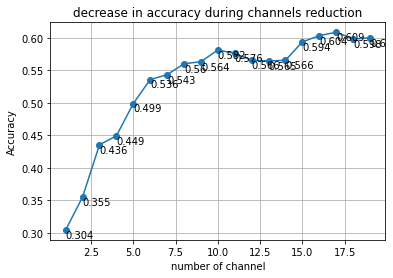

candidate of best selected channel:  [(18, 0.5983090705487123), (17, 0.608835386338186), (16, 0.6035610302351625), (15, 0.5940201567749159), (10, 0.581545352743561)]
maximum accuracy is 0.58 with 10 channel(s)


SubjectI-160723-epo.fif
Most used channel in all trial: 
 [('F7', 356), ('C3', 159), ('C4', 147), ('Fp2', 55), ('Fp1', 48), ('F8', 39), ('F4', 27), ('Fz', 26), ('P3', 23), ('Pz', 17), ('P4', 17), ('Cz', 15), ('T4', 10), ('F3', 7), ('T3', 6), ('O1', 3), ('O2', 3)]
Relevan channels in each class: 
 {'thumb': [('F7', 85), ('C4', 34), ('C3', 27)], 'index': [('F7', 62), ('C4', 31), ('C3', 21)], 'middle': [('F7', 66), ('C3', 45), ('C4', 32)], 'ring': [('F7', 70), ('C3', 27), ('C4', 26)], 'pinky': [('F7', 73), ('C3', 39), ('C4', 24)]}
dropped channel  O1
dropped channel  O2
dropped channel  T3
dropped channel  F3
dropped channel  T4
dropped channel  Cz
dropped channel  Pz
dropped channel  P4
dropped channel  P3
dropped channel  Fz
dropped channel  F4
dropped channel  F8
dropped channe

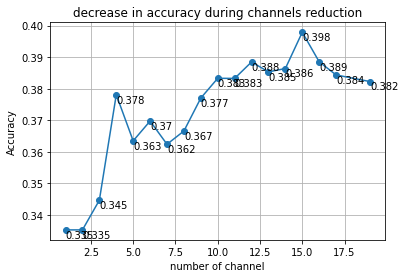

candidate of best selected channel:  [(17, 0.3843530701754386), (16, 0.3885197368421053), (15, 0.3978728070175438), (14, 0.38638157894736846), (13, 0.38532894736842105), (12, 0.38845394736842104), (11, 0.3832565789473684), (10, 0.3832894736842105), (9, 0.3770285087719299), (8, 0.36658991228070176), (7, 0.3624013157894737), (6, 0.3697478070175439), (5, 0.36347587719298247), (4, 0.37809210526315795)]
maximum accuracy is 0.38 with 4 channel(s)


SubjectG-160428-epo.fif
Most used channel in all trial: 
 [('C4', 335), ('C3', 327), ('Fp1', 80), ('P4', 40), ('Cz', 30), ('T4', 29), ('P3', 19), ('O2', 15), ('F3', 14), ('T3', 13), ('T5', 12), ('Fz', 7), ('F8', 6), ('O1', 6), ('F7', 6), ('Pz', 5), ('T6', 5), ('F4', 4), ('Fp2', 2)]
Relevan channels in each class: 
 {'thumb': [('C3', 80), ('C4', 58), ('Fp1', 22)], 'index': [('C4', 64), ('C3', 60), ('Fp1', 13)], 'middle': [('C4', 77), ('C3', 64), ('Fp1', 17)], 'ring': [('C4', 72), ('C3', 60), ('Fp1', 18)], 'pinky': [('C4', 64), ('C3', 63), ('T4', 11

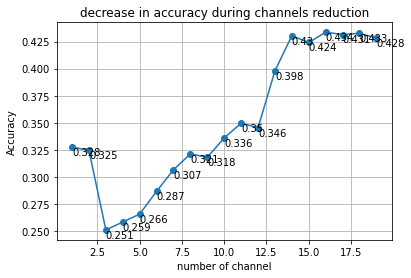

candidate of best selected channel:  [(18, 0.4325219298245614), (17, 0.43145833333333333), (16, 0.43356359649122805), (15, 0.4241118421052631), (14, 0.4303728070175438)]
maximum accuracy is 0.43 with 14 channel(s)


mean of selected channel number : 11
relevan channel in all subject (modus) : 
 [('C4', 4937), ('C3', 4849), ('Fz', 902), ('Cz', 858), ('T4', 811), ('Fp1', 802), ('P3', 717), ('F7', 702), ('P4', 601), ('F4', 509), ('T3', 505), ('F3', 448), ('F8', 262), ('Fp2', 259), ('T6', 193), ('Pz', 183), ('O1', 167), ('T5', 149), ('O2', 136)]
mean of all subject accuracy:  0.429


In [ ]:
accuracy = mainProgram(channel_selection='PCA', n_chan=1, n_chan_perclass =3,max_acc_decrease =0.02,
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

###STFT MRCP, SVM rbf

SubjectB-151110-epo.fif
Most used channel in all trial: 
 [('C4', 429), ('C3', 279), ('T4', 60), ('Cz', 48), ('Fp1', 26), ('T3', 22), ('P4', 21), ('Fz', 12), ('F4', 12), ('F7', 10), ('F3', 9), ('F8', 8), ('Fp2', 6), ('Pz', 6), ('P3', 4), ('T6', 4), ('T5', 2)]
Relevan channels in each class: 
 {'thumb': [('C4', 108), ('C3', 57), ('Cz', 14)], 'index': [('C4', 83), ('C3', 61), ('T4', 11)], 'middle': [('C4', 82), ('C3', 57), ('T4', 10)], 'ring': [('C4', 78), ('C3', 46), ('T4', 16)], 'pinky': [('C4', 78), ('C3', 58), ('T4', 13)]}
dropped channel  T5
dropped channel  T6
dropped channel  P3
dropped channel  Pz
dropped channel  Fp2
dropped channel  F8
dropped channel  F3
dropped channel  F7
dropped channel  F4
dropped channel  Fz
dropped channel  P4
dropped channel  T3
dropped channel  Fp1
dropped channel  Cz
dropped channel  T4
dropped channel  C3


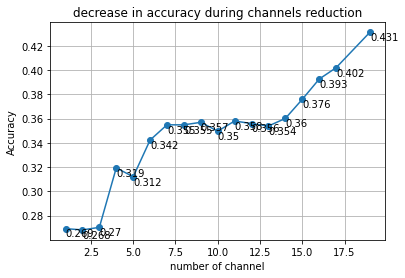

candidate of best selected channel:  []
maximum accuracy is 0.4 with 17 channel(s)


SubjectB-160316-epo.fif
Most used channel in all trial: 
 [('C3', 333), ('C4', 278), ('T3', 88), ('Fz', 80), ('Cz', 35), ('F7', 34), ('F3', 20), ('F8', 19), ('P3', 19), ('Fp1', 10), ('T4', 10), ('Fp2', 8), ('Pz', 7), ('T6', 7), ('P4', 5), ('F4', 4), ('T5', 1), ('O1', 1)]
Relevan channels in each class: 
 {'thumb': [('C4', 68), ('C3', 66), ('Fz', 22)], 'index': [('C3', 75), ('C4', 51), ('Fz', 18)], 'middle': [('C4', 62), ('C3', 60), ('T3', 21)], 'ring': [('C3', 63), ('C4', 53), ('T3', 26)], 'pinky': [('C3', 69), ('C4', 44), ('Fz', 15)]}
dropped channel  O1
dropped channel  T5
dropped channel  F4
dropped channel  P4
dropped channel  Pz
dropped channel  T6
dropped channel  Fp2
dropped channel  Fp1
dropped channel  T4
dropped channel  F8
dropped channel  P3
dropped channel  F3
dropped channel  F7
dropped channel  Cz
dropped channel  Fz
dropped channel  T3
dropped channel  C4


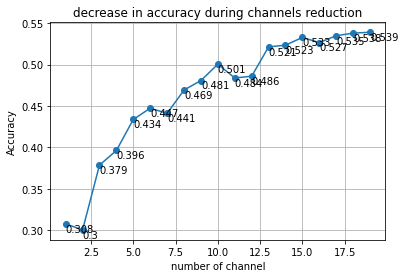

candidate of best selected channel:  [(18, 0.538048245614035), (17, 0.5349122807017543), (16, 0.526611842105263), (15, 0.5328508771929825), (14, 0.5234868421052631), (13, 0.5214035087719298)]
maximum accuracy is 0.52 with 13 channel(s)


SubjectC-151204-epo.fif
Most used channel in all trial: 
 [('C4', 503), ('C3', 240), ('T4', 60), ('Fp1', 53), ('Fp2', 16), ('F8', 16), ('Cz', 15), ('P4', 12), ('F7', 10), ('F3', 10), ('Pz', 6), ('T5', 6), ('Fz', 4), ('O1', 2), ('F4', 2), ('T3', 1), ('O2', 1), ('P3', 1)]
Relevan channels in each class: 
 {'thumb': [('C4', 76), ('C3', 45), ('Fp1', 15)], 'index': [('C4', 103), ('C3', 52), ('Fp1', 12)], 'middle': [('C4', 111), ('C3', 51), ('T4', 11)], 'ring': [('C4', 110), ('C3', 41), ('T4', 12)], 'pinky': [('C4', 103), ('C3', 51), ('T4', 16)]}
dropped channel  O2
dropped channel  T3
dropped channel  P3
dropped channel  F4
dropped channel  O1
dropped channel  Fz
dropped channel  Pz
dropped channel  T5
dropped channel  F3
dropped channel  F7
dropped channel

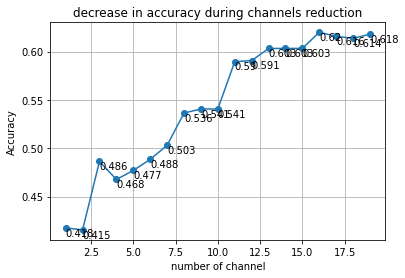

candidate of best selected channel:  [(18, 0.6137171052631578), (17, 0.6158223684210526), (16, 0.6200328947368421), (15, 0.6033223684210526), (14, 0.6033114035087719), (13, 0.603234649122807)]
maximum accuracy is 0.6 with 13 channel(s)


SubjectA-160405-epo.fif
Most used channel in all trial: 
 [('C3', 285), ('C4', 261), ('P3', 53), ('T4', 50), ('Cz', 36), ('T3', 36), ('Fz', 34), ('F8', 28), ('Pz', 26), ('F4', 23), ('F3', 23), ('F7', 22), ('O1', 22), ('T6', 19), ('O2', 13), ('Fp2', 11), ('Fp1', 9), ('P4', 6), ('T5', 2)]
Relevan channels in each class: 
 {'thumb': [('C3', 70), ('C4', 50), ('P3', 14)], 'index': [('C4', 52), ('C3', 46), ('P3', 10)], 'middle': [('C3', 63), ('C4', 58), ('T4', 11)], 'ring': [('C3', 55), ('C4', 48), ('Fz', 10)], 'pinky': [('C4', 53), ('C3', 51), ('T4', 14)]}
dropped channel  T5
dropped channel  P4
dropped channel  Fp1
dropped channel  Fp2
dropped channel  O2
dropped channel  T6
dropped channel  F7
dropped channel  O1
dropped channel  F3
dropped channel  F4
dr

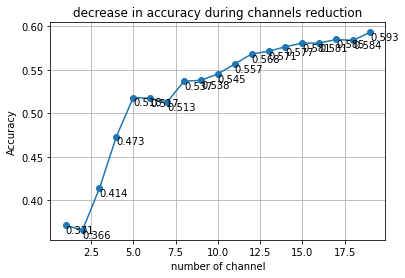

candidate of best selected channel:  [(18, 0.5839473684210528), (17, 0.5849671052631579), (16, 0.5808552631578947), (15, 0.5808223684210526), (14, 0.5766337719298245)]
maximum accuracy is 0.58 with 14 channel(s)


SubjectF-151027-epo.fif
Most used channel in all trial: 
 [('C3', 282), ('C4', 281), ('T6', 103), ('T4', 41), ('F7', 39), ('T3', 38), ('O1', 36), ('F3', 28), ('Cz', 19), ('F4', 17), ('P3', 17), ('Fp1', 14), ('P4', 14), ('F8', 10), ('Fp2', 8), ('O2', 4), ('Pz', 2), ('T5', 2), ('Fz', 2)]
Relevan channels in each class: 
 {'thumb': [('C4', 67), ('C3', 57), ('T6', 27)], 'index': [('C4', 61), ('C3', 41), ('T6', 20)], 'middle': [('C4', 62), ('C3', 44), ('T6', 22)], 'ring': [('C3', 76), ('C4', 40), ('O1', 16)], 'pinky': [('C3', 64), ('C4', 51), ('T6', 22)]}
dropped channel  Pz
dropped channel  Fz
dropped channel  T5
dropped channel  O2
dropped channel  Fp2
dropped channel  F8
dropped channel  Fp1
dropped channel  P4
dropped channel  P3
dropped channel  F4
dropped channel  Cz
dropped

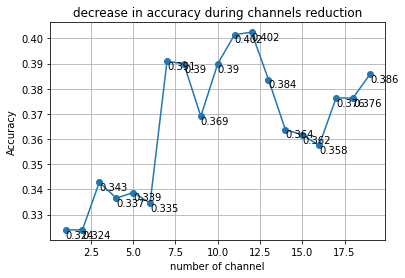

candidate of best selected channel:  [(18, 0.37633771929824567), (17, 0.37635964912280706), (13, 0.3836951754385965), (12, 0.4024780701754386), (11, 0.4015350877192983), (10, 0.3899561403508772), (9, 0.36906798245614036), (8, 0.3899013157894737), (7, 0.39097587719298244)]
maximum accuracy is 0.39 with 7 channel(s)


SubjectF-160209-epo.fif
Most used channel in all trial: 
 [('C4', 267), ('Fz', 245), ('P4', 223), ('F4', 54), ('T3', 46), ('C3', 32), ('F3', 21), ('Cz', 15), ('T5', 13), ('P3', 10), ('Fp2', 9), ('T4', 4), ('T6', 4), ('F7', 4), ('O1', 3), ('O2', 2), ('F8', 2), ('Pz', 2)]
Relevan channels in each class: 
 {'thumb': [('Fz', 62), ('C4', 56), ('P4', 42)], 'index': [('C4', 53), ('P4', 41), ('Fz', 37)], 'middle': [('C4', 62), ('Fz', 47), ('P4', 45)], 'ring': [('Fz', 48), ('P4', 47), ('C4', 46)], 'pinky': [('Fz', 51), ('C4', 50), ('P4', 48)]}
dropped channel  F8
dropped channel  Pz
dropped channel  O2
dropped channel  O1
dropped channel  F7
dropped channel  T4
dropped channel  T6
d

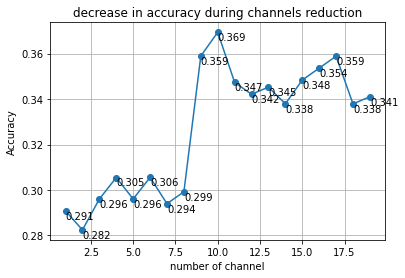

candidate of best selected channel:  [(18, 0.33787280701754396), (17, 0.358859649122807), (16, 0.3536184210526316), (15, 0.3483662280701754), (14, 0.33792763157894734), (13, 0.34525219298245613), (12, 0.34213815789473684), (11, 0.3473355263157895), (10, 0.3693969298245614), (9, 0.358936403508772)]
maximum accuracy is 0.36 with 9 channel(s)


SubjectA-160408-epo.fif
Most used channel in all trial: 
 [('C3', 290), ('C4', 281), ('T3', 57), ('Cz', 50), ('T4', 32), ('Fz', 30), ('P3', 25), ('F3', 15), ('P4', 14), ('T6', 14), ('F7', 12), ('Fp2', 11), ('F8', 9), ('O1', 7), ('Pz', 7), ('Fp1', 6), ('F4', 4), ('O2', 2), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [('C4', 68), ('C3', 66), ('Cz', 11)], 'index': [('C4', 53), ('C3', 43), ('T3', 17)], 'middle': [('C3', 68), ('C4', 49), ('T3', 14)], 'ring': [('C3', 58), ('C4', 52), ('Cz', 13)], 'pinky': [('C4', 59), ('C3', 55), ('T3', 10)]}
dropped channel  T5
dropped channel  O2
dropped channel  F4
dropped channel  Fp1
dropped channel  O1
d

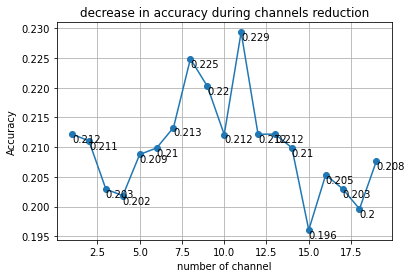

candidate of best selected channel:  [(18, 0.19958567228013896), (17, 0.2029938519112537), (16, 0.2053194333066025), (15, 0.1960572039561615), (14, 0.20989040363539163), (13, 0.21218925421010426), (12, 0.21217588879978616), (11, 0.22935044105854047), (10, 0.21212242715851376), (9, 0.22026196204223467), (8, 0.22487302860197808), (7, 0.21329858326650633), (6, 0.20985030740443728), (5, 0.2087677091686715), (4, 0.2018176958032612), (3, 0.20294039026998129), (2, 0.21103982892274792), (1, 0.21220261962042236)]
maximum accuracy is 0.21 with 1 channel(s)


SubjectI-160719-epo.fif
Most used channel in all trial: 
 [('C3', 288), ('C4', 256), ('F7', 133), ('F3', 44), ('F8', 39), ('P4', 32), ('Pz', 29), ('P3', 28), ('F4', 25), ('Fz', 24), ('Cz', 22), ('Fp2', 11), ('T4', 10), ('T3', 6), ('Fp1', 5), ('O1', 2), ('O2', 2), ('T6', 2), ('T5', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 60), ('C4', 59), ('F7', 32)], 'index': [('C4', 50), ('C3', 44), ('F7', 31)], 'middle': [('C3', 57), ('C4', 

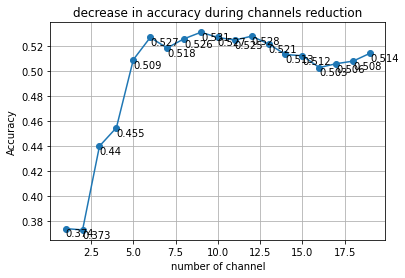

candidate of best selected channel:  [(18, 0.5078399122807017), (17, 0.5057894736842105), (16, 0.5027083333333333), (15, 0.5120833333333332), (14, 0.5131249999999998), (13, 0.5214802631578948), (12, 0.527719298245614), (11, 0.5246162280701754), (10, 0.5267105263157894), (9, 0.5308552631578947), (8, 0.525625), (7, 0.5183552631578947), (6, 0.5266885964912281), (5, 0.5089473684210526)]
maximum accuracy is 0.51 with 5 channel(s)


SubjectH-160804-epo.fif
Most used channel in all trial: 
 [('Fp1', 359), ('C4', 228), ('C3', 220), ('Cz', 30), ('Fp2', 13), ('F4', 12), ('P4', 9), ('Fz', 8), ('F7', 6), ('Pz', 6), ('O2', 5), ('P3', 5), ('O1', 5), ('F8', 5), ('T5', 4), ('T3', 3), ('F3', 1), ('T6', 1), ('T4', 1)]
Relevan channels in each class: 
 {'thumb': [('Fp1', 74), ('C4', 50), ('C3', 46)], 'index': [('Fp1', 79), ('C4', 44), ('C3', 31)], 'middle': [('Fp1', 73), ('C4', 48), ('C3', 46)], 'ring': [('Fp1', 74), ('C3', 54), ('C4', 35)], 'pinky': [('Fp1', 59), ('C4', 51), ('C3', 43)]}
dropped channel

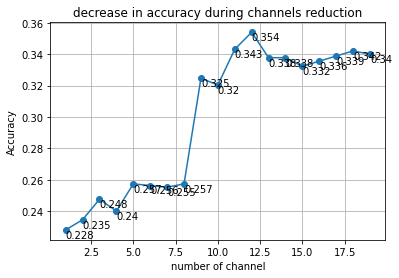

candidate of best selected channel:  [(18, 0.34209911173445534), (17, 0.338838242169238), (16, 0.3355656848994858), (15, 0.332328190743338), (14, 0.3377746610565685), (13, 0.3377629733520337), (12, 0.35399719495091164), (11, 0.34313931743805515), (10, 0.3203599812996728), (9, 0.3246727442730248)]
maximum accuracy is 0.32 with 9 channel(s)


SubjectF-160210-epo.fif
Most used channel in all trial: 
 [('C3', 302), ('C4', 175), ('P3', 145), ('T4', 112), ('T3', 42), ('F3', 42), ('Fp2', 32), ('Fz', 30), ('P4', 29), ('F8', 12), ('O1', 11), ('Fp1', 6), ('T6', 5), ('F4', 4), ('F7', 4), ('Cz', 3), ('Pz', 2), ('T5', 1), ('O2', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 67), ('C4', 40), ('T4', 28)], 'index': [('C3', 50), ('C4', 35), ('P3', 28)], 'middle': [('C3', 66), ('C4', 34), ('T4', 26)], 'ring': [('C3', 60), ('P3', 35), ('C4', 28)], 'pinky': [('C3', 59), ('P3', 39), ('C4', 38)]}
dropped channel  T5
dropped channel  O2
dropped channel  Pz
dropped channel  Cz
dropped channel  F7
dr

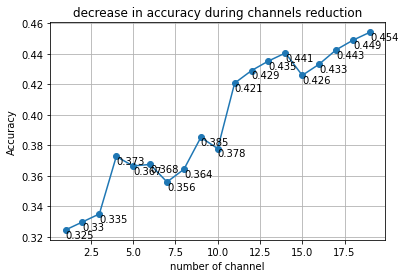

candidate of best selected channel:  [(18, 0.4490021929824562), (17, 0.44265350877192977), (14, 0.4405811403508772), (13, 0.4353508771929825)]
maximum accuracy is 0.44 with 13 channel(s)


SubjectG-160413-epo.fif
Most used channel in all trial: 
 [('C3', 334), ('C4', 237), ('Fp1', 68), ('P3', 66), ('P4', 56), ('Fz', 41), ('Cz', 38), ('Pz', 17), ('F7', 12), ('F8', 12), ('O2', 10), ('F3', 9), ('T3', 9), ('F4', 9), ('Fp2', 8), ('T4', 8), ('T5', 6), ('T6', 3), ('O1', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 73), ('C4', 44), ('P3', 18)], 'index': [('C3', 57), ('C4', 48), ('P3', 10)], 'middle': [('C3', 75), ('C4', 41), ('Fp1', 21)], 'ring': [('C3', 77), ('C4', 47), ('P4', 14)], 'pinky': [('C4', 57), ('C3', 52), ('P3', 17)]}
dropped channel  O1
dropped channel  T6
dropped channel  T5
dropped channel  Fp2
dropped channel  T4
dropped channel  F3
dropped channel  F4
dropped channel  T3
dropped channel  O2
dropped channel  F8
dropped channel  F7
dropped channel  Pz
dropped channel 

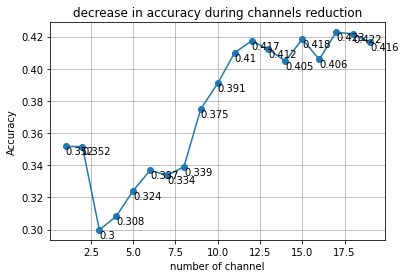

candidate of best selected channel:  [(18, 0.4216797312430011), (17, 0.42270996640537517), (16, 0.4058006718924972), (15, 0.41845464725643894), (14, 0.40468085106382984), (13, 0.4120604703247481), (12, 0.4173796192609182), (11, 0.40995520716685335)]
maximum accuracy is 0.41 with 11 channel(s)


SubjectB-160311-epo.fif
Most used channel in all trial: 
 [('C3', 336), ('C4', 276), ('T4', 231), ('Cz', 22), ('F7', 21), ('F4', 13), ('P3', 11), ('P4', 10), ('F8', 10), ('Fp2', 8), ('T6', 4), ('Fz', 4), ('T3', 4), ('Fp1', 4), ('Pz', 3), ('F3', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 72), ('C4', 64), ('T4', 43)], 'index': [('C3', 63), ('C4', 51), ('T4', 37)], 'middle': [('C3', 68), ('C4', 58), ('T4', 55)], 'ring': [('C3', 64), ('C4', 52), ('T4', 51)], 'pinky': [('C3', 69), ('C4', 51), ('T4', 45)]}
dropped channel  F3
dropped channel  Pz
dropped channel  Fz
dropped channel  Fp1
dropped channel  T6
dropped channel  T3
dropped channel  Fp2
dropped channel  P4
dropped channel  F8
dro

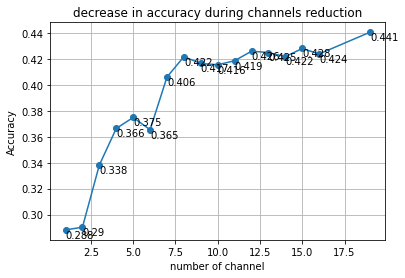

candidate of best selected channel:  [(16, 0.42388157894736844), (15, 0.4280811403508772), (14, 0.4217982456140351), (13, 0.42496710526315795), (12, 0.42598684210526316), (8, 0.42175438596491227)]
maximum accuracy is 0.42 with 8 channel(s)


SubjectB-160309-epo.fif
Most used channel in all trial: 
 [('C3', 465), ('C4', 168), ('P3', 58), ('Cz', 36), ('Fp1', 33), ('P4', 29), ('Fz', 23), ('F7', 17), ('F3', 17), ('F8', 17), ('Pz', 17), ('Fp2', 15), ('T4', 13), ('T3', 9), ('F4', 9), ('T6', 5), ('T5', 3), ('O2', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 104), ('C4', 33), ('P3', 15)], 'index': [('C3', 84), ('C4', 27), ('Fp1', 8)], 'middle': [('C3', 91), ('C4', 42), ('P3', 11)], 'ring': [('C3', 95), ('C4', 29), ('P3', 13)], 'pinky': [('C3', 91), ('C4', 37), ('Cz', 11)]}
dropped channel  O2
dropped channel  T5
dropped channel  T6
dropped channel  F4
dropped channel  T3
dropped channel  T4
dropped channel  Fp2
dropped channel  F3
dropped channel  Pz
dropped channel  F7
dropped chan

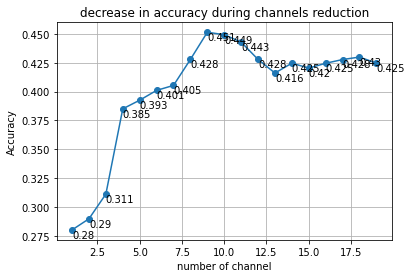

candidate of best selected channel:  [(18, 0.4298901853122855), (17, 0.427739647677877), (16, 0.42452528025623426), (15, 0.4203385952871196), (14, 0.4245939144360558), (13, 0.41606039807824297), (12, 0.427831159917639), (11, 0.4428620452985587), (10, 0.4492679020819034), (9, 0.4513955616563715), (8, 0.42785403797757954), (7, 0.4053305879661405)]
maximum accuracy is 0.41 with 7 channel(s)


SubjectC-160429-epo.fif
Most used channel in all trial: 
 [('C3', 404), ('C4', 398), ('Cz', 44), ('P4', 18), ('Fz', 14), ('T4', 11), ('F4', 8), ('F3', 7), ('T3', 7), ('Fp1', 6), ('Pz', 5), ('Fp2', 5), ('O1', 4), ('F8', 3), ('T5', 3), ('P3', 2), ('O2', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 85), ('C4', 84), ('Cz', 14)], 'index': [('C4', 74), ('C3', 70), ('Cz', 9)], 'middle': [('C3', 81), ('C4', 77), ('Cz', 12)], 'ring': [('C4', 86), ('C3', 79), ('Fz', 6)], 'pinky': [('C3', 89), ('C4', 77), ('Cz', 5)]}
dropped channel  O2
dropped channel  P3
dropped channel  F8
dropped channel  T5
drop

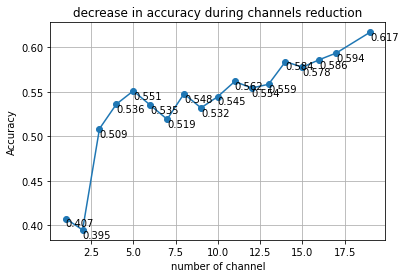

candidate of best selected channel:  []
maximum accuracy is 0.59 with 17 channel(s)


SubjectE-160321-epo.fif
Most used channel in all trial: 
 [('Cz', 193), ('P3', 174), ('C3', 119), ('C4', 109), ('T3', 83), ('T5', 56), ('O1', 33), ('T4', 32), ('Fz', 30), ('O2', 29), ('Fp2', 20), ('P4', 20), ('Pz', 19), ('Fp1', 12), ('F8', 11), ('F4', 8), ('F7', 7), ('T6', 1)]
Relevan channels in each class: 
 {'thumb': [('C3', 38), ('Cz', 37), ('P3', 35)], 'index': [('P3', 40), ('Cz', 38), ('C3', 22)], 'middle': [('Cz', 43), ('P3', 40), ('C4', 30)], 'ring': [('Cz', 41), ('P3', 28), ('C3', 19)], 'pinky': [('Cz', 34), ('P3', 31), ('C4', 24)]}
dropped channel  T6
dropped channel  F7
dropped channel  F4
dropped channel  F8
dropped channel  Fp1
dropped channel  Pz
dropped channel  Fp2
dropped channel  P4
dropped channel  O2
dropped channel  Fz
dropped channel  T4
dropped channel  O1
dropped channel  T5
dropped channel  T3
dropped channel  C4
dropped channel  C3
dropped channel  P3


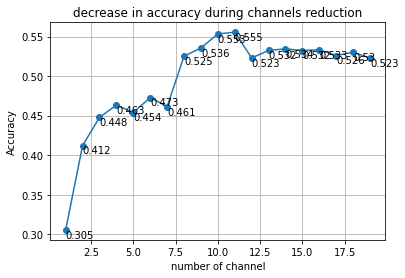

candidate of best selected channel:  [(18, 0.5301973684210526), (17, 0.5259868421052631), (16, 0.5333662280701754), (15, 0.532313596491228), (14, 0.5344627192982456), (13, 0.5324013157894736), (12, 0.5229605263157895), (11, 0.5554605263157895), (10, 0.553344298245614), (9, 0.535548245614035), (8, 0.5251754385964913)]
maximum accuracy is 0.53 with 8 channel(s)


SubjectE-160429-epo.fif
Most used channel in all trial: 
 [('F4', 241), ('C4', 187), ('F3', 149), ('T4', 89), ('Cz', 55), ('Fz', 49), ('C3', 47), ('Fp1', 33), ('O2', 23), ('P3', 17), ('Fp2', 16), ('P4', 11), ('F7', 8), ('F8', 7), ('O1', 6), ('T6', 4), ('T3', 3), ('Pz', 1)]
Relevan channels in each class: 
 {'thumb': [('F4', 53), ('C4', 39), ('F3', 32)], 'index': [('F4', 58), ('C4', 23), ('F3', 23)], 'middle': [('F4', 42), ('F3', 38), ('C4', 31)], 'ring': [('F4', 48), ('C4', 47), ('F3', 26)], 'pinky': [('C4', 47), ('F4', 40), ('F3', 30)]}
dropped channel  Pz
dropped channel  T3
dropped channel  T6
dropped channel  O1
dropped chan

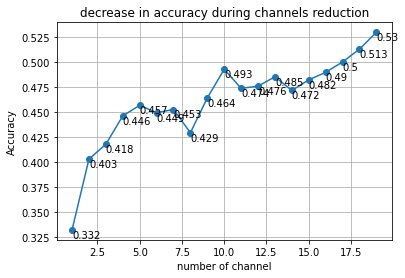

candidate of best selected channel:  [(18, 0.512956326987682)]
maximum accuracy is 0.51 with 18 channel(s)


SubjectE-160415-epo.fif
Most used channel in all trial: 
 [('Fz', 239), ('Cz', 152), ('C4', 121), ('C3', 107), ('P3', 40), ('T5', 36), ('P4', 35), ('F4', 33), ('T3', 32), ('F3', 31), ('Fp1', 30), ('O1', 25), ('O2', 24), ('T6', 12), ('F8', 9), ('T4', 8), ('Pz', 6), ('Fp2', 5), ('F7', 1)]
Relevan channels in each class: 
 {'thumb': [('Fz', 41), ('Cz', 29), ('C4', 28)], 'index': [('Fz', 43), ('Cz', 25), ('C4', 21)], 'middle': [('Fz', 50), ('Cz', 31), ('C4', 25)], 'ring': [('Fz', 51), ('Cz', 30), ('C4', 23)], 'pinky': [('Fz', 54), ('Cz', 37), ('C4', 24)]}
dropped channel  F7
dropped channel  Fp2
dropped channel  Pz
dropped channel  T4
dropped channel  F8
dropped channel  T6
dropped channel  O2
dropped channel  O1
dropped channel  Fp1
dropped channel  F3
dropped channel  T3
dropped channel  F4
dropped channel  P4
dropped channel  T5
dropped channel  P3
dropped channel  C3
dropped cha

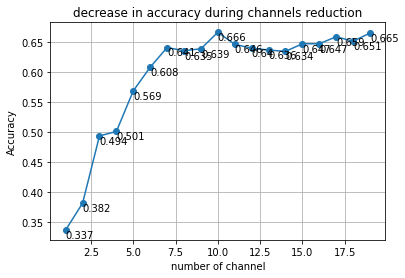

candidate of best selected channel:  [(18, 0.6511758118701008), (17, 0.6587010078387459), (16, 0.647043673012318), (15, 0.646976483762598), (11, 0.6460022396416574), (10, 0.6661814109742441)]
maximum accuracy is 0.67 with 10 channel(s)


SubjectI-160723-epo.fif
Most used channel in all trial: 
 [('F7', 356), ('C3', 159), ('C4', 147), ('Fp2', 55), ('Fp1', 48), ('F8', 39), ('F4', 27), ('Fz', 26), ('P3', 23), ('Pz', 17), ('P4', 17), ('Cz', 15), ('T4', 10), ('F3', 7), ('T3', 6), ('O1', 3), ('O2', 3)]
Relevan channels in each class: 
 {'thumb': [('F7', 85), ('C4', 34), ('C3', 27)], 'index': [('F7', 62), ('C4', 31), ('C3', 21)], 'middle': [('F7', 66), ('C3', 45), ('C4', 32)], 'ring': [('F7', 70), ('C3', 27), ('C4', 26)], 'pinky': [('F7', 73), ('C3', 39), ('C4', 24)]}
dropped channel  O1
dropped channel  O2
dropped channel  T3
dropped channel  F3
dropped channel  T4
dropped channel  Cz
dropped channel  Pz
dropped channel  P4
dropped channel  P3
dropped channel  Fz
dropped channel  F4
dropped 

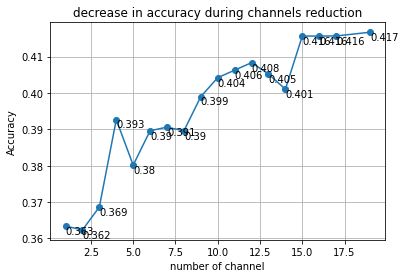

candidate of best selected channel:  [(17, 0.4156907894736842), (16, 0.4156688596491228), (15, 0.41564692982456136), (14, 0.4010526315789473), (13, 0.4052412280701755), (12, 0.40834429824561413), (11, 0.40628289473684215), (10, 0.4042214912280702), (9, 0.39901315789473685)]
maximum accuracy is 0.4 with 9 channel(s)


SubjectG-160428-epo.fif
Most used channel in all trial: 
 [('C4', 335), ('C3', 327), ('Fp1', 80), ('P4', 40), ('Cz', 30), ('T4', 29), ('P3', 19), ('O2', 15), ('F3', 14), ('T3', 13), ('T5', 12), ('Fz', 7), ('F8', 6), ('O1', 6), ('F7', 6), ('Pz', 5), ('T6', 5), ('F4', 4), ('Fp2', 2)]
Relevan channels in each class: 
 {'thumb': [('C3', 80), ('C4', 58), ('Fp1', 22)], 'index': [('C4', 64), ('C3', 60), ('Fp1', 13)], 'middle': [('C4', 77), ('C3', 64), ('Fp1', 17)], 'ring': [('C4', 72), ('C3', 60), ('Fp1', 18)], 'pinky': [('C4', 64), ('C3', 63), ('T4', 11)]}
dropped channel  Fp2
dropped channel  F4
dropped channel  Pz
dropped channel  T6
dropped channel  O1
dropped channel  F8
dro

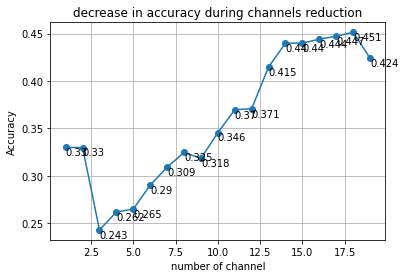

candidate of best selected channel:  [(18, 0.451326754385965), (17, 0.4471271929824561), (16, 0.4439912280701754), (15, 0.43979166666666664), (14, 0.4398245614035088), (13, 0.4147149122807018)]
maximum accuracy is 0.41 with 13 channel(s)


mean of selected channel number : 11
relevan channel in all subject (modus) : 
 [('C4', 4937), ('C3', 4849), ('Fz', 902), ('Cz', 858), ('T4', 811), ('Fp1', 802), ('P3', 717), ('F7', 702), ('P4', 601), ('F4', 509), ('T3', 505), ('F3', 448), ('F8', 262), ('Fp2', 259), ('T6', 193), ('Pz', 183), ('O1', 167), ('T5', 149), ('O2', 136)]
mean of all subject accuracy:  0.457


In [ ]:
accuracy = mainProgram(channel_selection='PCA', n_chan=1, n_chan_perclass =3,max_acc_decrease =0.02,
                       features_extraction='STFT', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

##Manual channel selection using sensorymotor channels

In [ ]:
accuracy = mainProgram(channel_selection='manual', manual_subset = ['C3','Cz','C4', 'P4'],#'P4','P3',
                       features_extraction='STFT', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use ['C3', 'Cz', 'C4', 'P4']
Accuracy per fold: [0.323 0.302 0.323 0.323 0.302 0.375 0.281 0.312 0.358 0.305]
Mean of Subject accuracy:  0.32


SubjectB-160316-epo.fif
Use ['C3', 'Cz', 'C4', 'P4']
Accuracy per fold: [0.469 0.469 0.438 0.458 0.427 0.479 0.396 0.375 0.5   0.484]
Mean of Subject accuracy:  0.449


SubjectC-151204-epo.fif
Use ['C3', 'Cz', 'C4', 'P4']
Accuracy per fold: [0.583 0.5   0.49  0.615 0.552 0.49  0.521 0.51  0.537 0.4  ]
Mean of Subject accuracy:  0.52


SubjectA-160405-epo.fif
Use ['C3', 'Cz', 'C4', 'P4']
Accuracy per fold: [0.281 0.49  0.469 0.448 0.458 0.458 0.365 0.458 0.521 0.484]
Mean of Subject accuracy:  0.443


SubjectF-151027-epo.fif
Use ['C3', 'Cz', 'C4', 'P4']
Accuracy per fold: [0.406 0.271 0.333 0.281 0.292 0.323 0.312 0.358 0.253 0.326]
Mean of Subject accuracy:  0.316


SubjectF-160209-epo.fif
Use ['C3', 'Cz', 'C4', 'P4']
Accuracy per fold: [0.312 0.312 0.323 0.26  0.312 0.354 0.316 0.326 0.347 0.411]
Mean of Subject accurac

In [ ]:
accuracy = mainProgram(channel_selection='manual', manual_subset = ['C3','Cz','C4','Fz','Pz','F3','F4','P3','P4','O1','O2'],#'P4','P3',
                       features_extraction='STFT', FTA_lfreq=0, FTA_hfreq=5,
                       SVMkernel='rbf', split=0.27, nfold=10)

SubjectB-151110-epo.fif
Use ['C3', 'Cz', 'C4', 'Fz', 'Pz', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
Accuracy per fold: [0.354 0.417 0.427 0.385 0.469 0.448 0.302 0.323 0.463 0.368]
Mean of Subject accuracy:  0.396


SubjectB-160316-epo.fif
Use ['C3', 'Cz', 'C4', 'Fz', 'Pz', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
Accuracy per fold: [0.542 0.573 0.51  0.51  0.521 0.521 0.5   0.458 0.51  0.547]
Mean of Subject accuracy:  0.519


SubjectC-151204-epo.fif
Use ['C3', 'Cz', 'C4', 'Fz', 'Pz', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
Accuracy per fold: [0.625 0.646 0.615 0.708 0.594 0.552 0.635 0.625 0.611 0.568]
Mean of Subject accuracy:  0.618


SubjectA-160405-epo.fif
Use ['C3', 'Cz', 'C4', 'Fz', 'Pz', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
Accuracy per fold: [0.51  0.542 0.448 0.562 0.542 0.542 0.562 0.583 0.573 0.516]
Mean of Subject accuracy:  0.538


SubjectF-151027-epo.fif
Use ['C3', 'Cz', 'C4', 'Fz', 'Pz', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
Accuracy per fold: [0.479 0.417 0.333 0.302 0.354 0.406 0.406

##Spatial Plotting

In [ ]:
classes=['thumb','index','middle','ring','pinky']
for subject,title in zip(dataset_list,list_title):
  for epochclass in classes :
    title_class = title + ' ' + epochclass
    evoked = subject[epochclass].average()
    evoked.plot_joint(title=title_class)
  print('\n')

In [ ]:
classes=['thumb','index','middle','ring','pinky']
for subject,title in zip(dataset_list,list_title):
  for epochclass in classes :
    title_class = title + ' ' + epochclass
    evoked = subject[epochclass].average()
    evoked.plot_topomap(title=title_class)
  print('\n')

##FTA plotting

In [ ]:
def FTAplotting(dataset,picks,kind):
  '''
  input: dataset
         picks = one channel which you want to plot

  '''
  EEG_class={}
  EEG_class["thumb"] = dataset['thumb'].get_data(picks=picks)
  EEG_class["index"] = dataset['index'].get_data(picks=picks)
  EEG_class["middle"] = dataset['middle'].get_data(picks=picks)
  EEG_class["ring"] = dataset['ring'].get_data(picks=picks)
  EEG_class["pinky"] = dataset['pinky'].get_data(picks=picks)

  freq = scipy.fft.rfftfreq(170, 1./200)
  sum = np.zeros(5)
  count  = 0

  mean_FTA={}

  #each class
  for key,value in EEG_class.items():
    for trial in value:
      fta = scipy.fft.rfft(trial[0]) # len 86
      #get fta in frequency frequency range: lfreq - hfreq
      band = fta[np.where((freq>=0) & (freq<=5))]
      count +=1
      if kind == 'real':
        sum += np.real(band)
        mean_FTA[key] =np.real (band) #(fta) #sum/count #
      elif kind == 'imag':
        sum += np.imag(band)
        mean_FTA[key] =np.imag(band) #(fta) #sum/count #
      x=(list(range(0,len(mean_FTA[key]))))
    plt.plot(x,mean_FTA[key],label=key,marker='o')
  plt.title('Plot FTA pada kanal {} ({})'.format(picks,kind))
  plt.grid()
  plt.xlabel('frekuensi (Hz)')
  plt.ylabel('Amplituda')
  plt.legend()
  plt.show

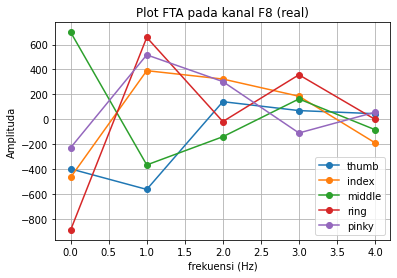

In [ ]:
FTAplotting(dataset_list[16],'F8','real')

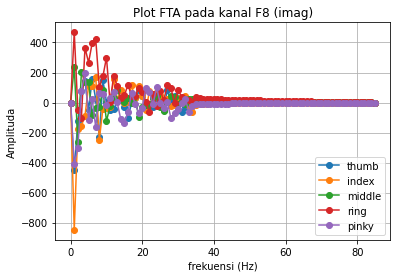

In [ ]:
FTAplotting(dataset_list[16],'F8','imag')

In [ ]:
def FTAplotting_perclass(dataset,picks,kind):
  '''
  input: dataset
         picks = one channel which you want to plot

  '''
  EEG_class={}
  EEG_class["thumb"] = dataset['thumb'].get_data(picks=picks)
  EEG_class["index"] = dataset['index'].get_data(picks=picks)
  EEG_class["middle"] = dataset['middle'].get_data(picks=picks)
  EEG_class["ring"] = dataset['ring'].get_data(picks=picks)
  EEG_class["pinky"] = dataset['pinky'].get_data(picks=picks)

  freq = scipy.fft.rfftfreq(170, 1./200)
  sum = np.zeros(5)
  count  = 0

  mean_FTA={}

  #each class
  value = EEG_class['thumb']
  for trial in value:
    fta = scipy.fft.rfft(trial[0]) # len 86
    #get fta in frequency frequency range: lfreq - hfreq
    band = fta[np.where((freq>=0) & (freq<=5))]
    count +=1
    if kind == 'real':
      sum += np.real(band)
      mean_FTA[key] =np.real(fta) #sum/count #
    elif kind == 'imag':
      sum += np.imag(band)
      mean_FTA[key] =np.imag(fta) #sum/count #
    x=(list(range(0,len(mean_FTA[key]))))
  plt.plot(x,mean_FTA[key],label=key,marker='o')
  plt.title('Plot FTA pada kanal {} ({})'.format(picks,kind))
  plt.grid()
  plt.xlabel('frekuensi (Hz)')
  plt.ylabel('Amplituda')
  plt.legend()
  plt.show

In [ ]:
FTAplotting_perclass(dataset_list[16],'F8','real')

NameError: ignored

In [ ]:
FTAplotting(dataset_list[0],'Fz','imag')

In [ ]:
FTAplotting(dataset_list[0],'F7','real')

In [ ]:
FTAplotting(dataset_list[0],'F7','imag')

In [ ]:
FTAplotting(dataset_list[0],'T6','real')

In [ ]:
FTAplotting(dataset_list[0],'T6','imag')

## STFT plotting


In [ ]:
def plot_STFT(dataset, picks, lfreq, hfreq):

  features_dict ={}
                  
  if picks is not None:
    data = dataset.get_data(picks=picks)
  else:
    data = dataset.get_data(picks='eeg')

  trial = data[0]
  channel= trial[0]
  #print(len(channel))
  #for channel in trial:
  f,t,zxx= scipy.signal.stft(channel,nperseg=9,noverlap=4, fs=200) 
  print(f)
  print(t)
  print(len(zxx))
  #get fta in frequency frequency range: lfreq - hfreq
  band = zxx[np.where((f>=lfreq) & (f<=hfreq))]
  print(band)

  '''plt.pcolormesh(t, f, zxx)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.show()'''

In [ ]:
plot_STFT(dataset_list[16], 'F8', 0, 5)

[ 0.         22.22222222 44.44444444 66.66666667 88.88888889]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85 ]
5


In [ ]:
plot_STFT(dataset_list[16], 'F8', 0, 5)

[ 0.         22.22222222 44.44444444 66.66666667 88.88888889]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85 ]
5
[[ 40.67381514+0.j  54.20401057+0.j  53.87890376+0.j  45.58101328+0.j
   50.52217204+0.j  87.8747984 +0.j 154.52196902+0.j 177.00520256+0.j
  145.60679957+0.j 100.64515222+0.j  61.70732617+0.j  44.15405622+0.j
   29.74451079+0.j  20.59223609+0.j   9.6713384 +0.j   5.17933796+0.j
   -7.29630775+0.j -10.98012093+0.j -14.20829616+0.j  -9.07470117+0.j
   -8.44723629+0.j  -7.24856919+0.j -15.30325998+0.j -22.27051401+0.j
  -24.23663382+0.j -18.95854923+0.j -15.65361805+0.j -18.2391349 +0.j
  -25.73183018+0.j -31.67746377+0.j -29.54136624+0.j -20.4870701 +0.j
  -18.24493549+0.j -13.51358051+0.j  -5.25429914+0.j]]


##Keluaran Tiap Step

In [ ]:
subject =dataset_list[16]
#get spatial pattern
SF_dict,CSP_dict = CSP(subject)
#rank channel contribution score
for key,value in CSP_dict.items():
  print('Spatial Pattern of {} \n{}'.format(key,np.round(np.abs(value[:,0]),3)))

Spatial Pattern of thumb 
[0.14  0.371 0.035 0.179 0.058 0.015 0.174 0.039 0.04  0.009 0.038 0.494
 0.042 0.181 0.064 0.037 0.158 0.032 0.175]
Spatial Pattern of index 
[0.014 0.007 0.016 0.011 0.014 0.009 0.044 0.01  0.067 0.029 0.014 0.025
 0.006 0.025 0.064 0.012 0.022 0.004 0.046]
Spatial Pattern of middle 
[0.023 0.14  0.033 0.017 0.076 0.018 0.033 0.037 0.028 0.04  0.034 0.071
 0.037 0.002 0.054 0.043 0.002 0.044 0.005]
Spatial Pattern of ring 
[0.086 0.075 0.124 0.013 0.096 0.007 0.114 0.159 0.093 0.104 0.123 0.132
 0.033 0.042 0.051 0.113 0.099 0.051 0.11 ]
Spatial Pattern of pinky 
[0.269 0.174 0.258 0.014 0.099 0.088 0.155 0.155 0.1   0.138 0.261 0.022
 0.137 0.15  0.019 0.159 0.191 0.015 0.192]


In [ ]:
def print_PCA(dataset):
  
  ch_names = dataset.ch_names

  #assign each EEG class matrix to dictionary
  EEG_class ={}
  EEG_class["thumb"] = dataset['thumb'].get_data(picks='eeg')
  EEG_class["index"] = dataset['index'].get_data(picks='eeg')
  EEG_class["middle"] = dataset['middle'].get_data(picks='eeg')
  EEG_class["ring"] = dataset['ring'].get_data(picks='eeg')
  EEG_class["pinky"] = dataset['pinky'].get_data(picks='eeg')

  perclass = {}
  rank_all = {}

  for key,data in EEG_class.items():
    subset_dict = {}
    #pick first trial each class
    trial = data[0]
    #normalized the data
    X = trial - np.mean(trial)
    A = np.cov(X)

    eigenval,eigenvec = scipy.linalg.eig(A)

    PCrank = []
    for row in eigenvec:
      PCrank.append(max(np.abs(row)))
    print('Principal component of {} \n{}'.format(key,np.round(np.abs(PCrank),3)))


In [ ]:
print_PCA(dataset_list[16])

Principal component of thumb 
[0.786 0.635 0.643 0.498 0.69  0.699 0.708 0.647 0.578 0.535 0.628 0.662
 0.563 0.524 0.458 0.63  0.566 0.846 0.392]
Principal component of index 
[0.685 0.538 0.66  0.553 0.709 0.691 0.67  0.647 0.657 0.54  0.628 0.513
 0.549 0.516 0.501 0.642 0.67  0.552 0.461]
Principal component of middle 
[0.614 0.59  0.661 0.56  0.588 0.68  0.704 0.574 0.677 0.578 0.688 0.406
 0.554 0.487 0.495 0.568 0.625 0.649 0.52 ]
Principal component of ring 
[0.706 0.529 0.631 0.469 0.681 0.665 0.656 0.615 0.741 0.633 0.591 0.448
 0.478 0.385 0.559 0.608 0.566 0.725 0.531]
Principal component of pinky 
[0.675 0.511 0.682 0.684 0.695 0.701 0.599 0.702 0.643 0.628 0.686 0.476
 0.443 0.425 0.512 0.696 0.662 0.661 0.426]


##Input 0-5 Hz EEG time domain

if you want to run cells bellow, you must change storage ID to 'methodMRCP(0-5Hz)'. because all 'result cells' above are for data from 'methodMRCP (0-40Hz)' 

In [ ]:
#No Channel Selection
accuracy = mainProgram(channel_selection=None, 
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10,Confusions=True)

In [ ]:
#Multiclass CSP
accuracy = mainProgram(channel_selection='multiclassCSP',n_chan_perclass=3,max_acc_decrease =0.02,
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

In [ ]:
#PCA
accuracy = mainProgram(channel_selection='PCA', n_chan=1, n_chan_perclass =3,max_acc_decrease =0.02,
                       features_extraction='FTA', FTA_lfreq=0, FTA_hfreq=5, FTAmethod='allAmplitude',
                       SVMkernel='rbf', split=0.27, nfold=10)

In [ ]:
#Spatial Plotting
classes=['thumb','index','middle','ring','pinky']
for subject,title in zip(dataset_list,list_title):
  for epochclass in classes :
    title = title + ' ' + epochclass
    evoked = subject[epochclass].average()
    evoked.plot_joint(title=title)
  print('\n')

##Summary

Rata-rata akurasi menggunakan semua kanal

fitur:
- Bandpower (beta rythm): 23,7%
- FTA (MRCP): 46,5% --> kernel : svm.SVC linear
- FTA (MRCP): 40,3% --> kernel : svm.SVC rbf

Akurasi klasifikasi sinyal EEG berbanding lurus dengan jumlah kanal yang digunakan (Shan et al)

Hasil seleksi kanal menggunakan CSP (fitur FTA)

- rata2 jumlah kanal terpilih: 5
- rata2 akurasi sebelum seleksi kanal: 40%
- rata2 akurasi setelah seleksi kanal:39%

Hasil seleksi kanal menggunakan PCA (fitur FTA)

- rata2 jumlah kanal terpilih:10
- rata2 akurasi sebelum seleksi kanal: 40%
- rata2 akurasi setelah seleksi kanal:40%

Masalah:
- Jumlah kanal terseleksi menggunakan PCA masih terlalu besar
- Kanal yang dianggap relevan tidak berada di sekitar area sensorimotor cortex (C3, Cz, dan C4)

Rencana perbaikan:
- memperbaiki seleksi kanal PCA --> menambahkan kriteria seberapa besar penurunan akurasi yanag diperbolehkan untuk mendapatkan jumlah kanal paling sedikit.
- mencoba mencari metode seleksi kanal baru.